In [1]:
from pathlib import Path
from importlib import reload
import matplotlib.pyplot as plt
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.auto import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import sys
sys.path.insert(0, '/app')
from torch.utils.tensorboard import SummaryWriter
from lib.utils import plot_hist, score_func

In [2]:
from models.model import Model
from models.gaussian import DiscreteGauss

In [3]:
seed = 52
logdir = Path('/_data/richgan/runs')
tag = 'discrite'
# Вспомогательная функция, чтобы генерить одинаковые модели для каждой частицы
def get_model():
    model = DiscreteGauss(
        n_bins=15
    )
    
    return Model(
        model,
        QuantileTransformer(output_distribution='normal', random_state=seed),
        QuantileTransformer(output_distribution='normal', random_state=seed),
        simulate_error_codes=True,
    )


In [4]:
data_dir = Path('/_data/data_csv/')

dataframes = {}
for file in tqdm(data_dir.iterdir()):
    name = file.stem.split('_')[1]
    train, test = train_test_split(pd.read_csv(file.as_posix(), dtype=np.float32), random_state=seed)
    dataframes[name]  =  {'train': train, 'test': test}
    
condition_cols = ['TrackP', 'TrackEta', 'NumLongTracks']
target_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']

proton :  0.164560658242633
RichDLLbt


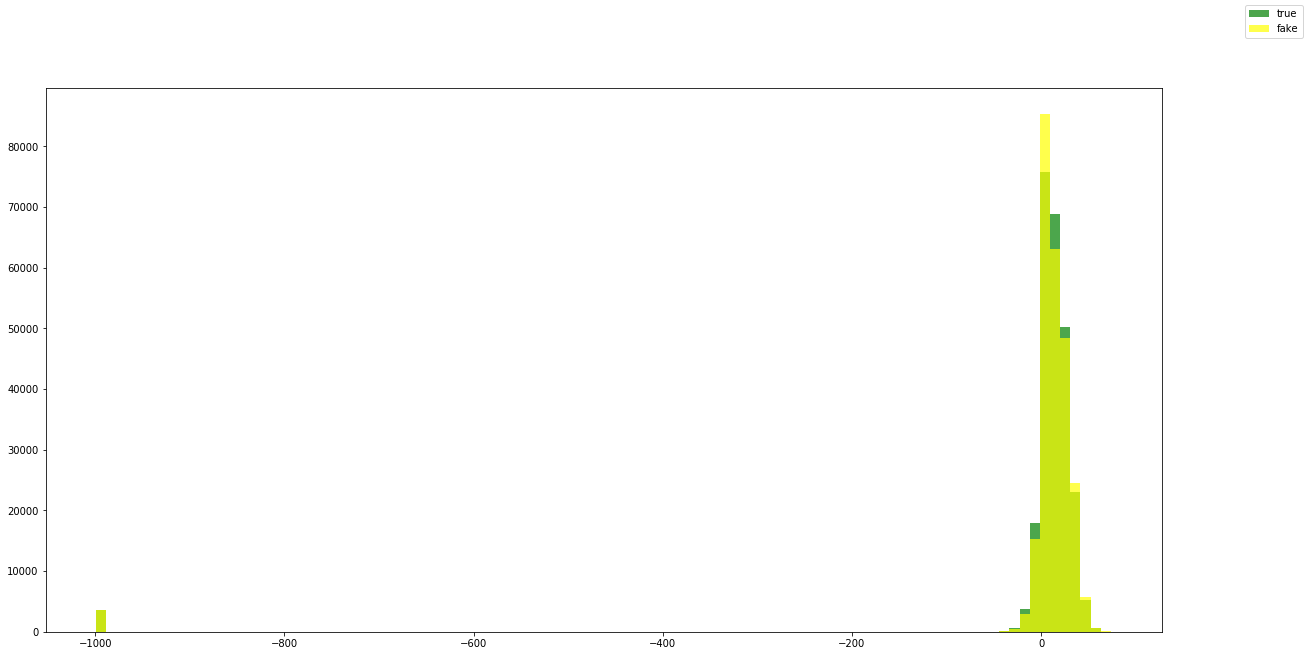

RichDLLk


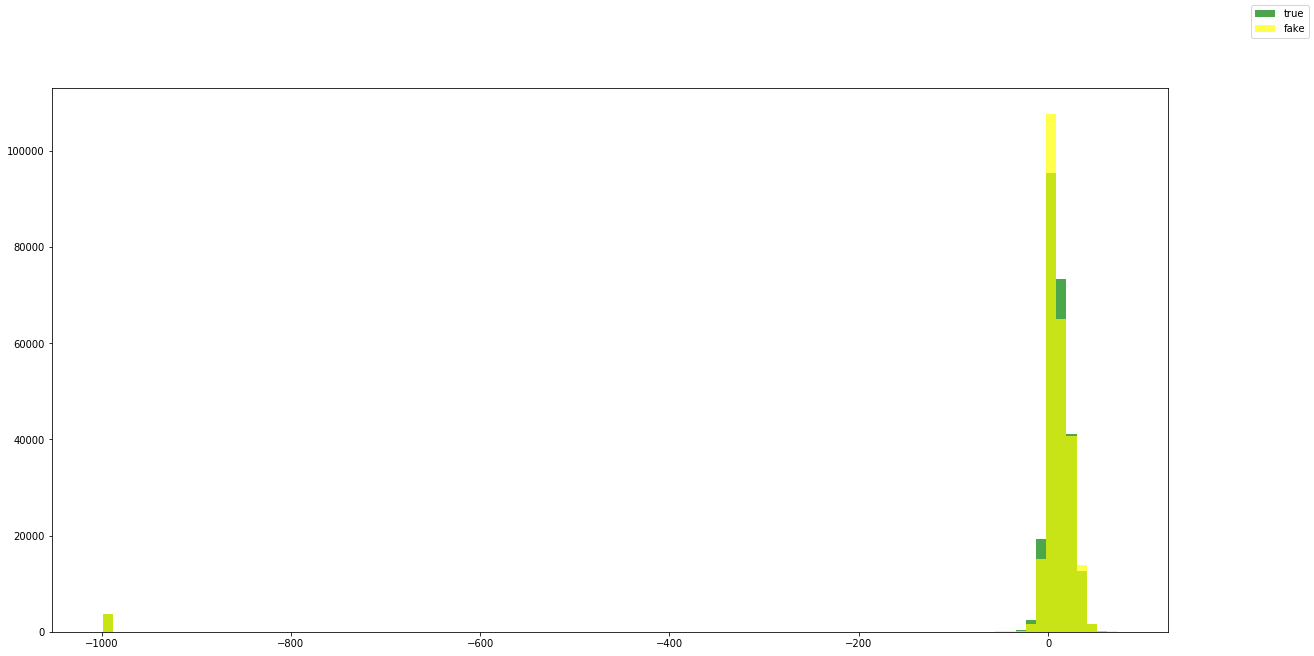

RichDLLmu


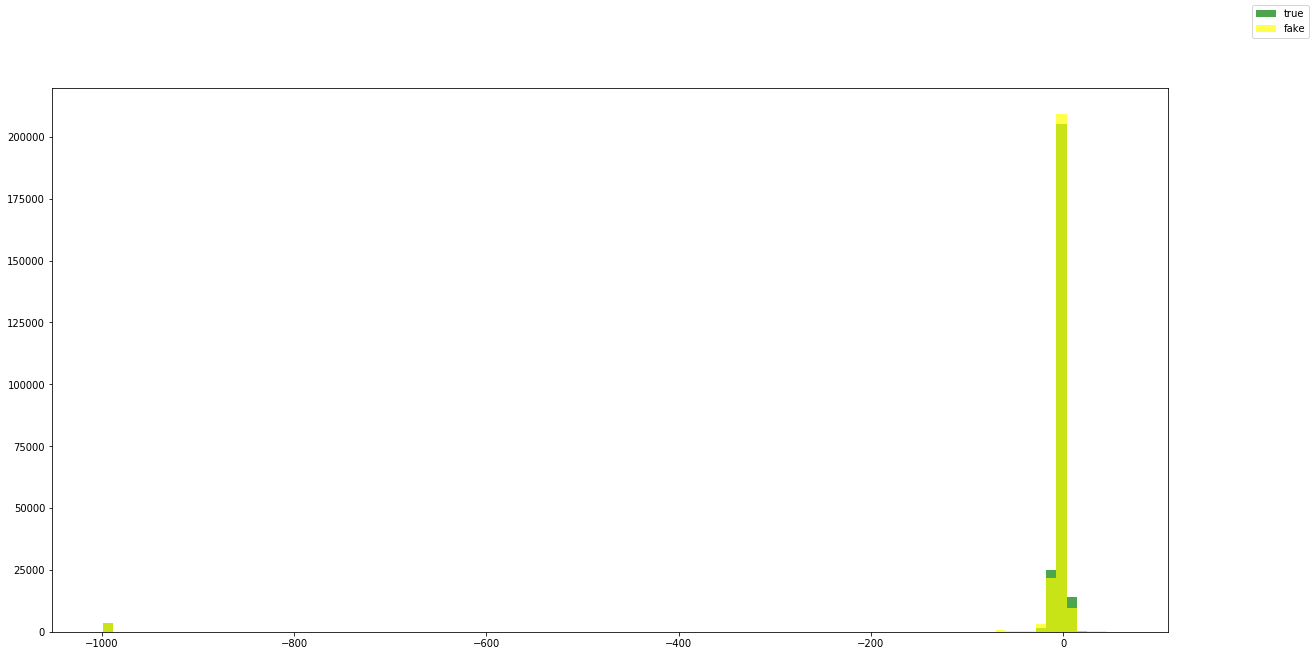

RichDLLp


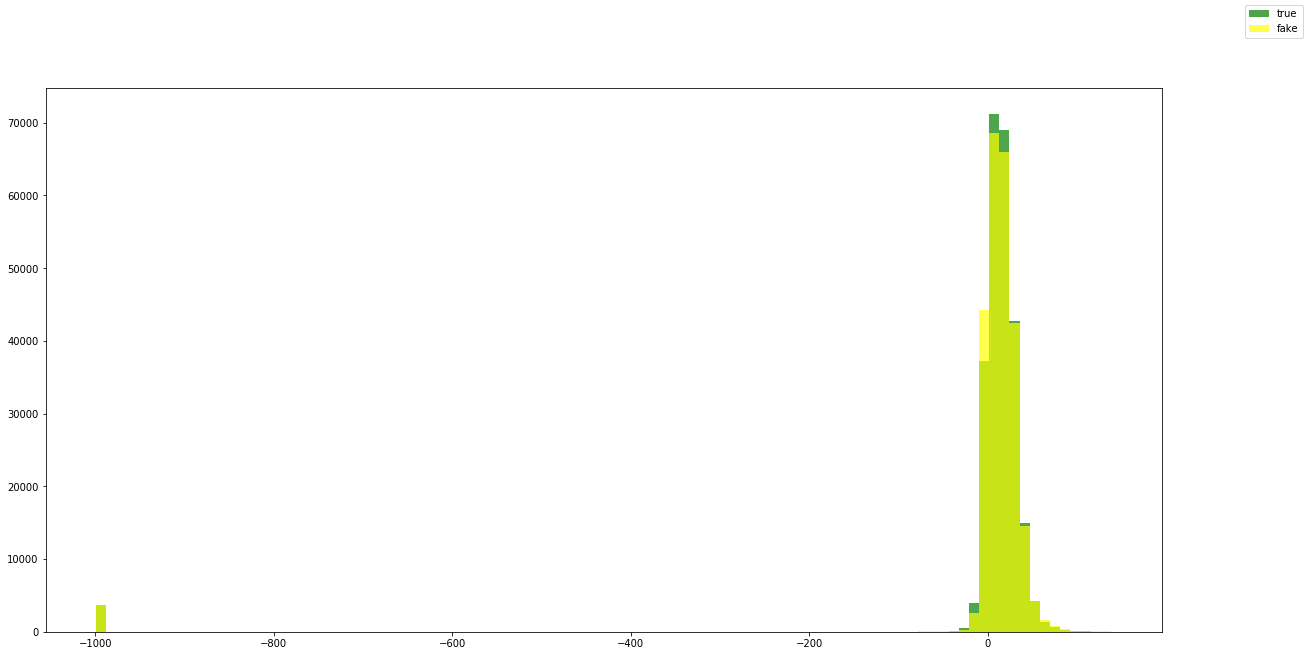

RichDLLe


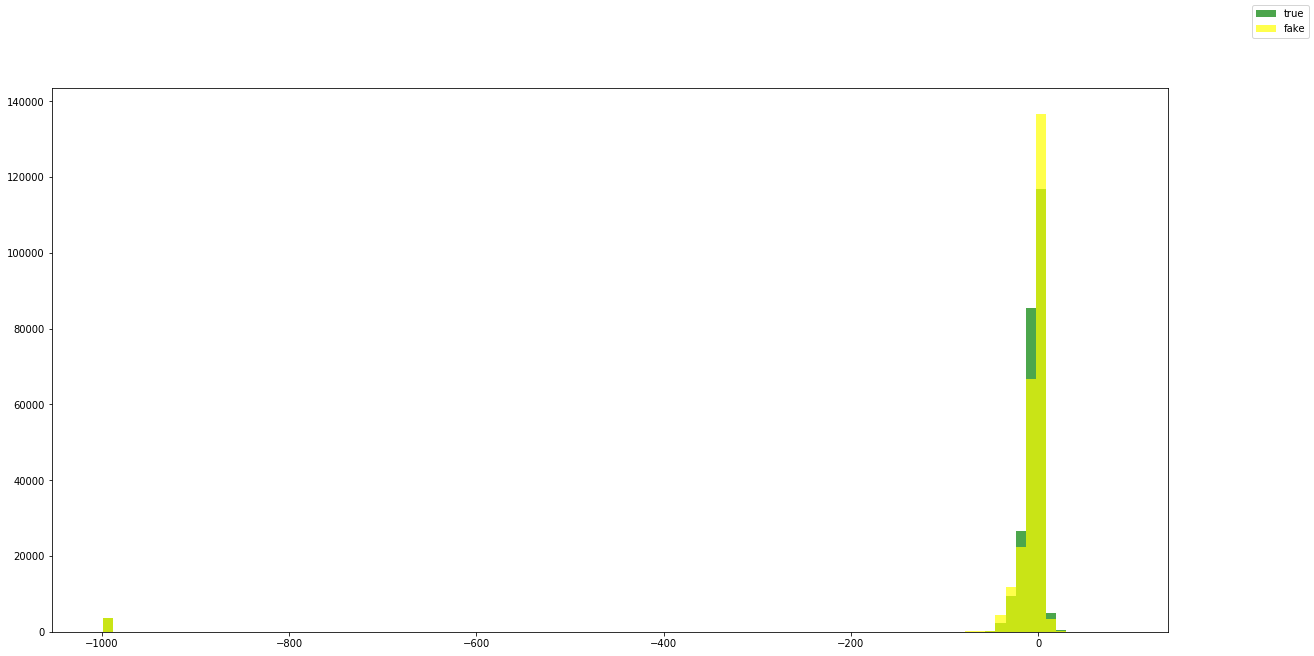

muon :  0.18015527937888243
RichDLLbt


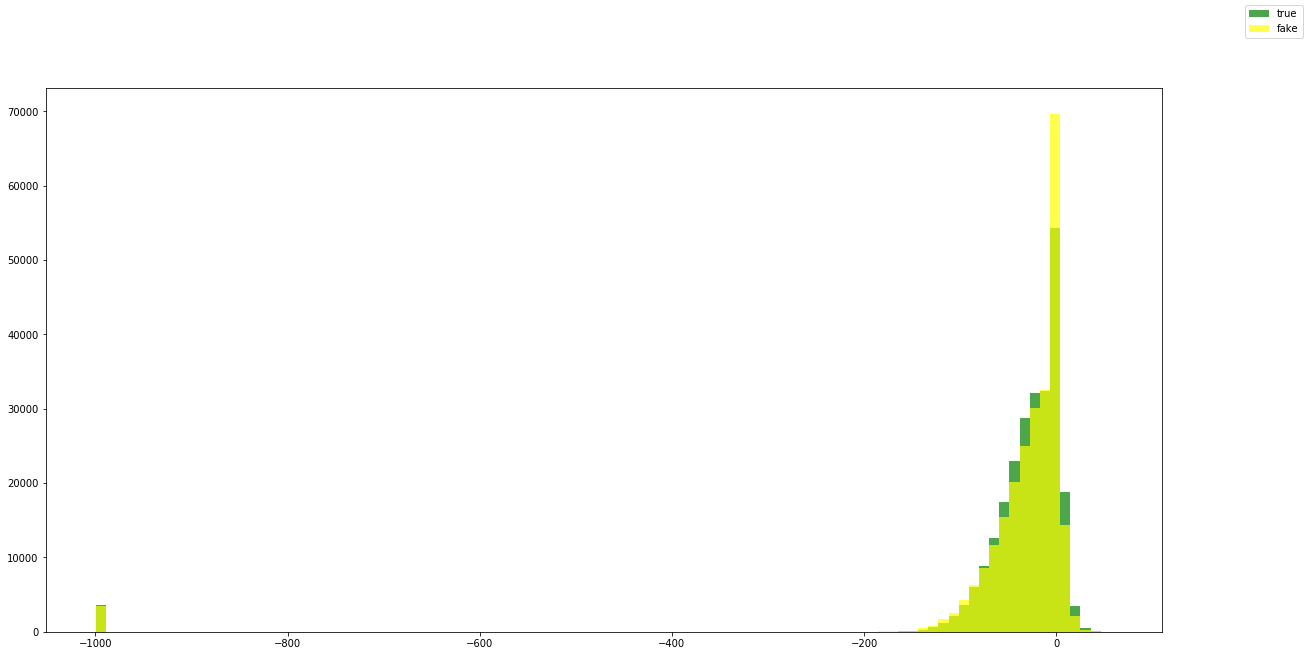

RichDLLk


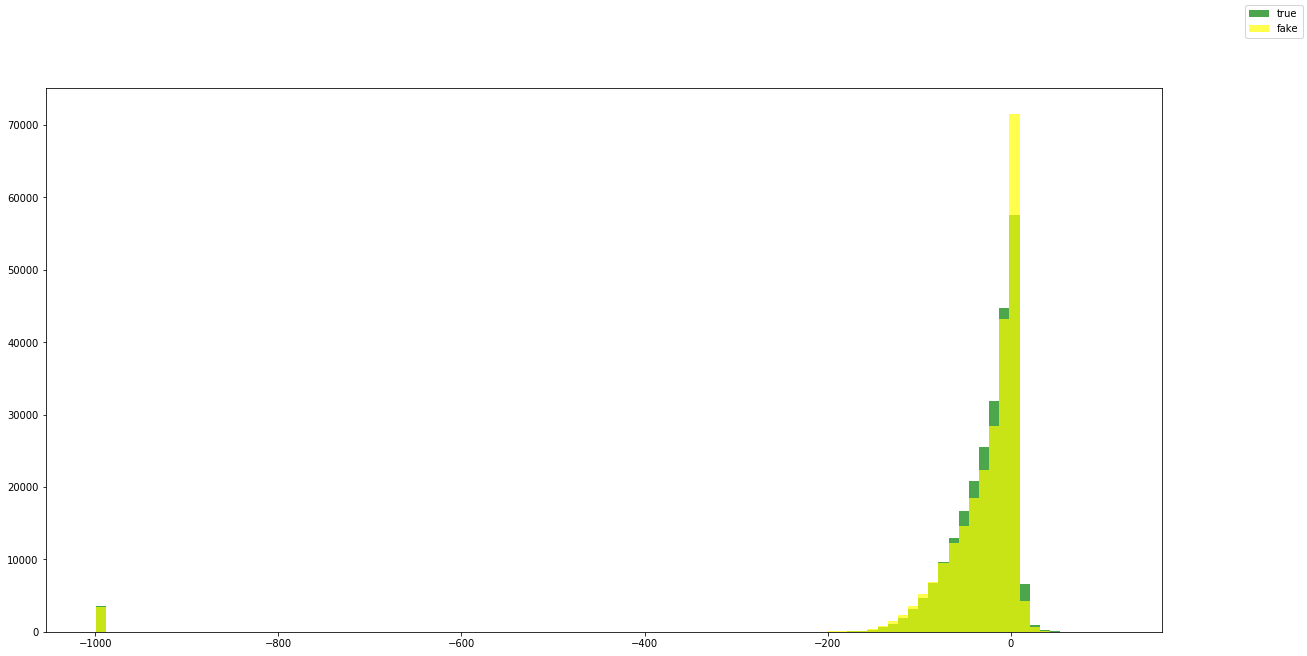

RichDLLmu


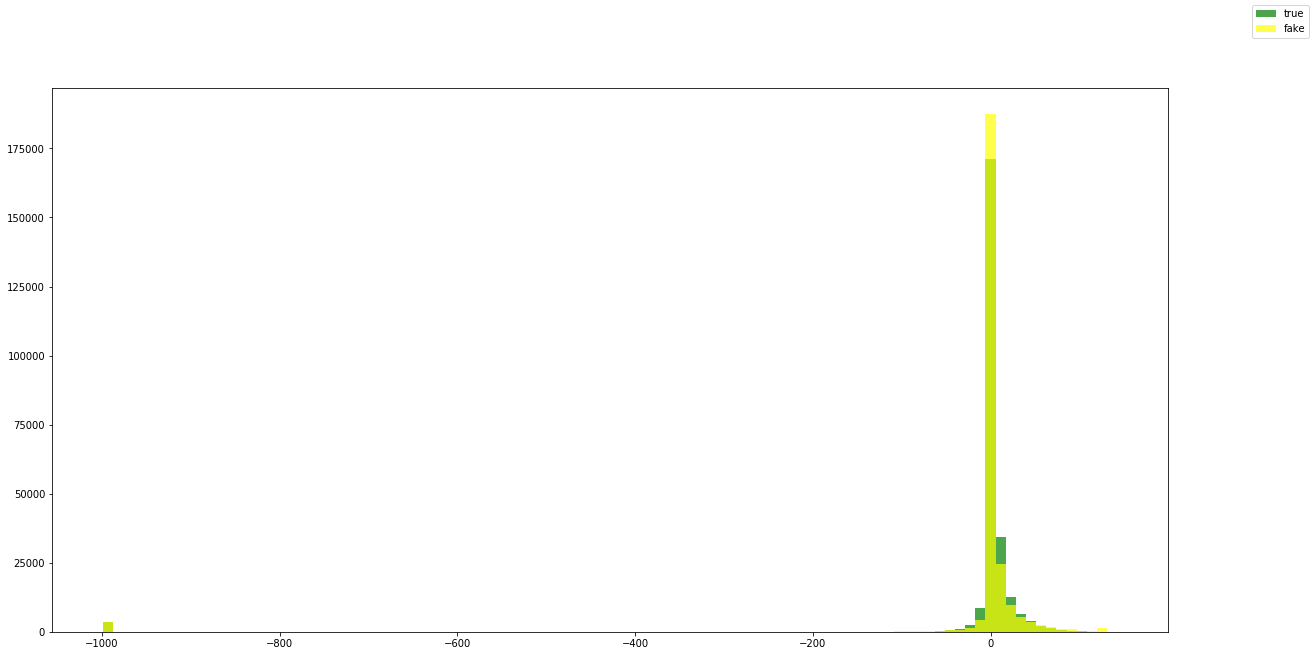

RichDLLp


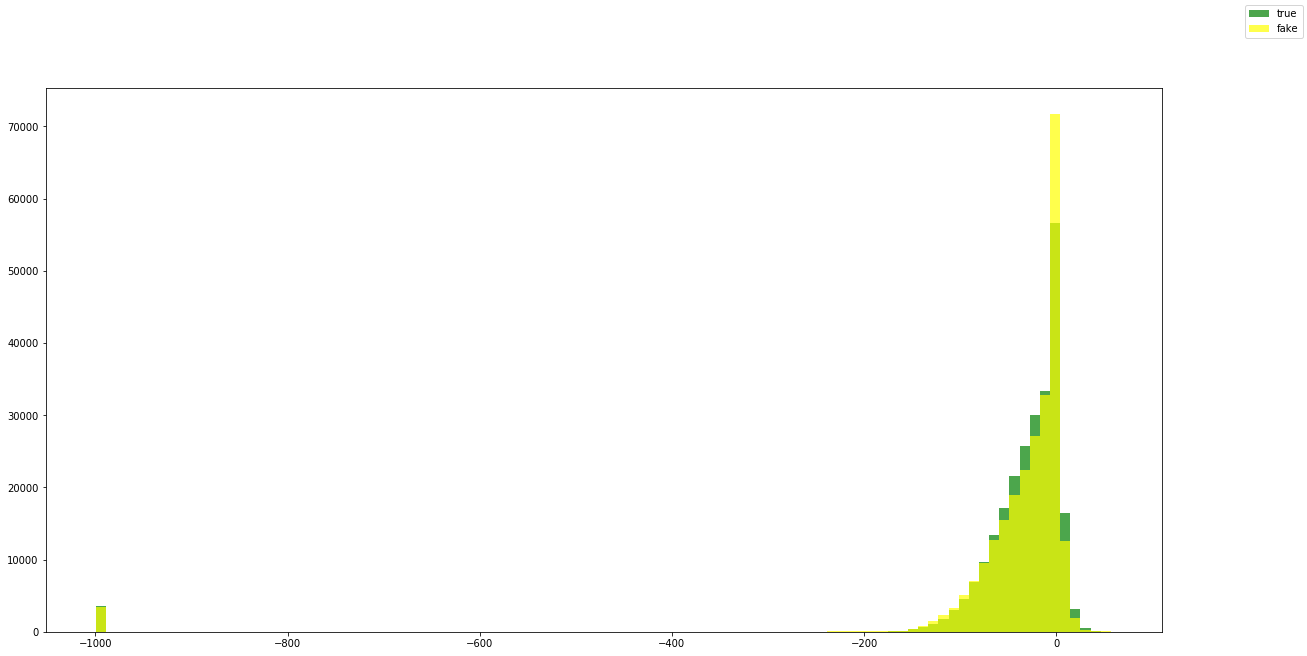

RichDLLe


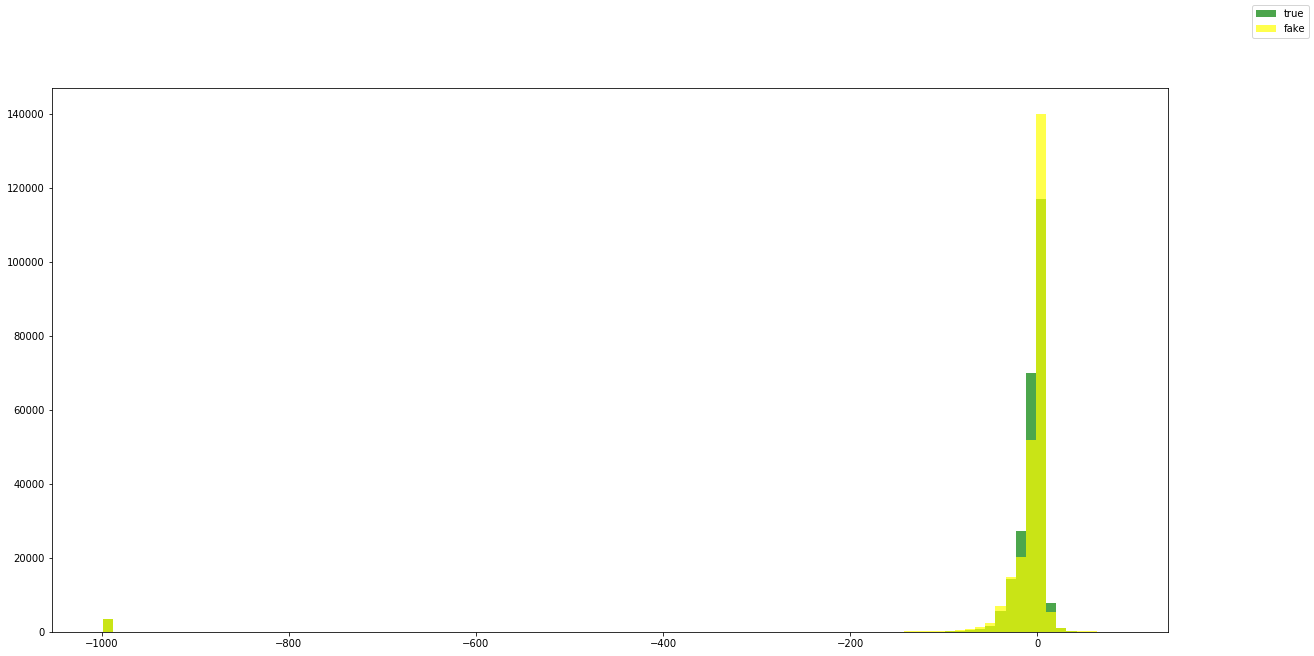

kaon :  0.1610326441305765
RichDLLbt


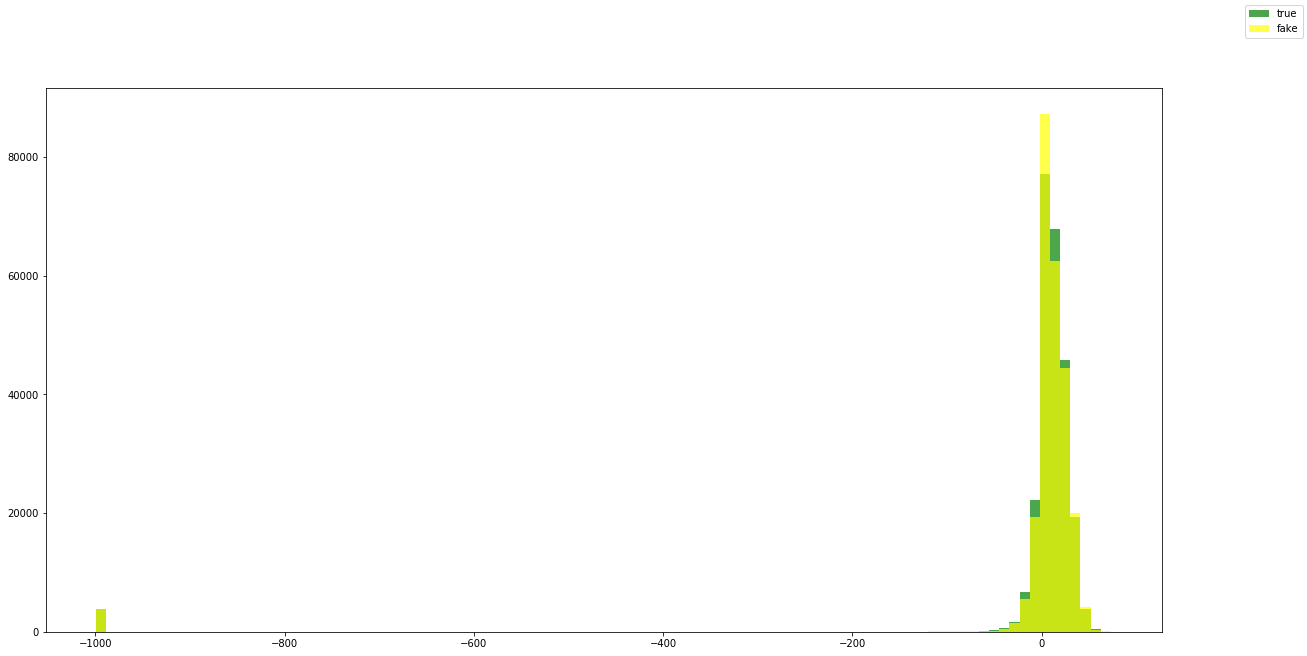

RichDLLk


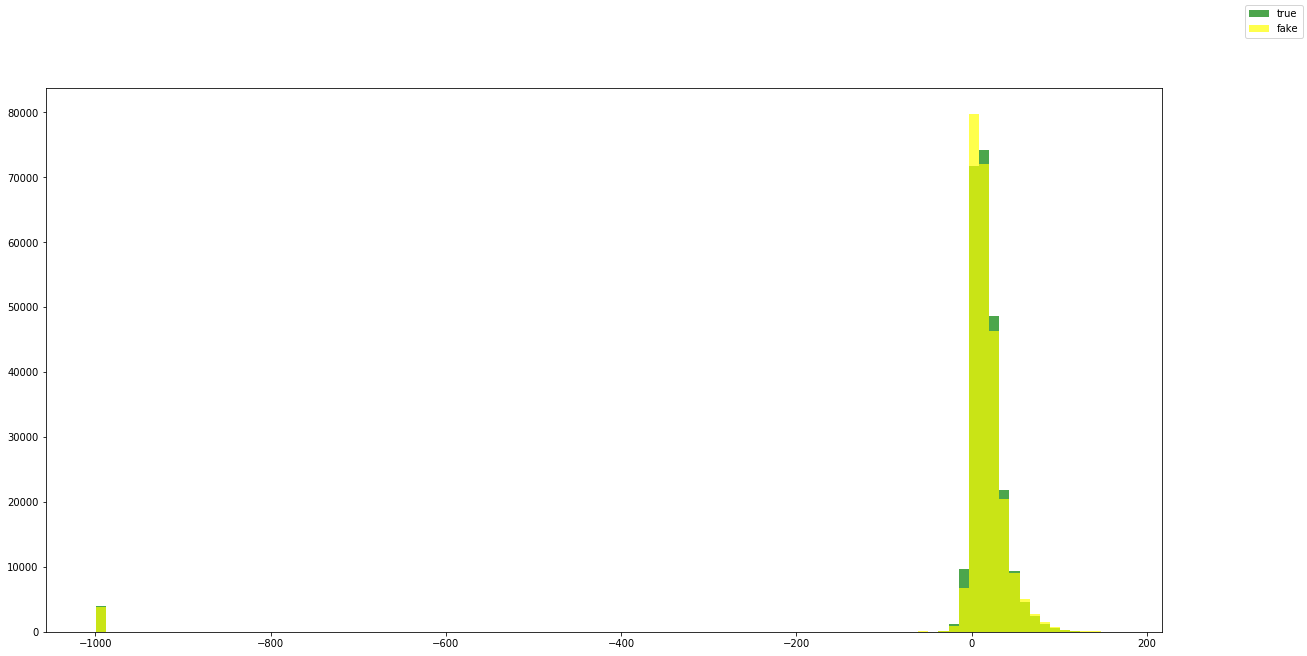

RichDLLmu


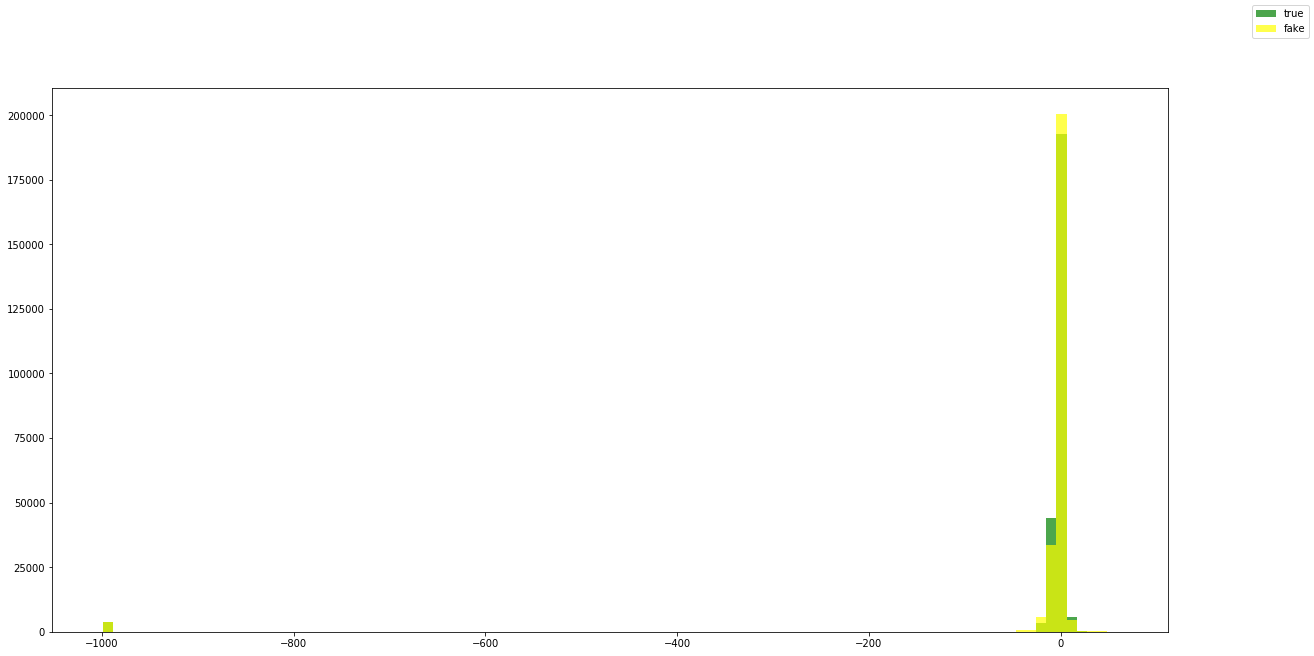

RichDLLp


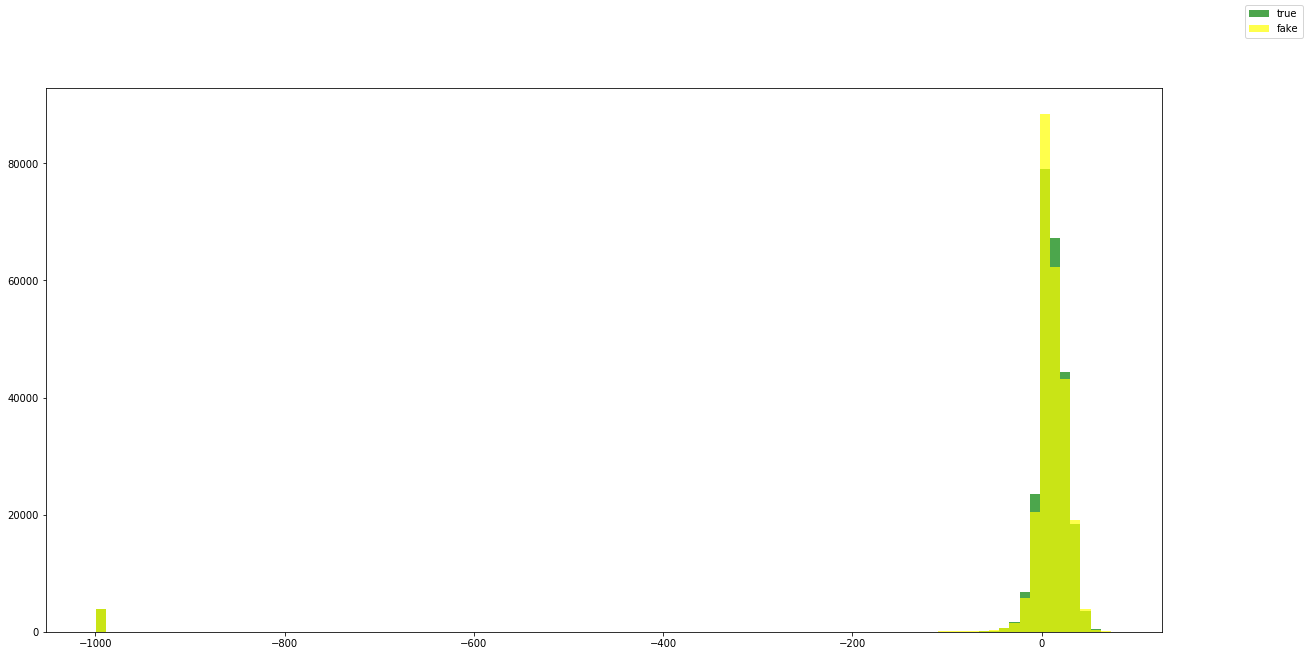

RichDLLe


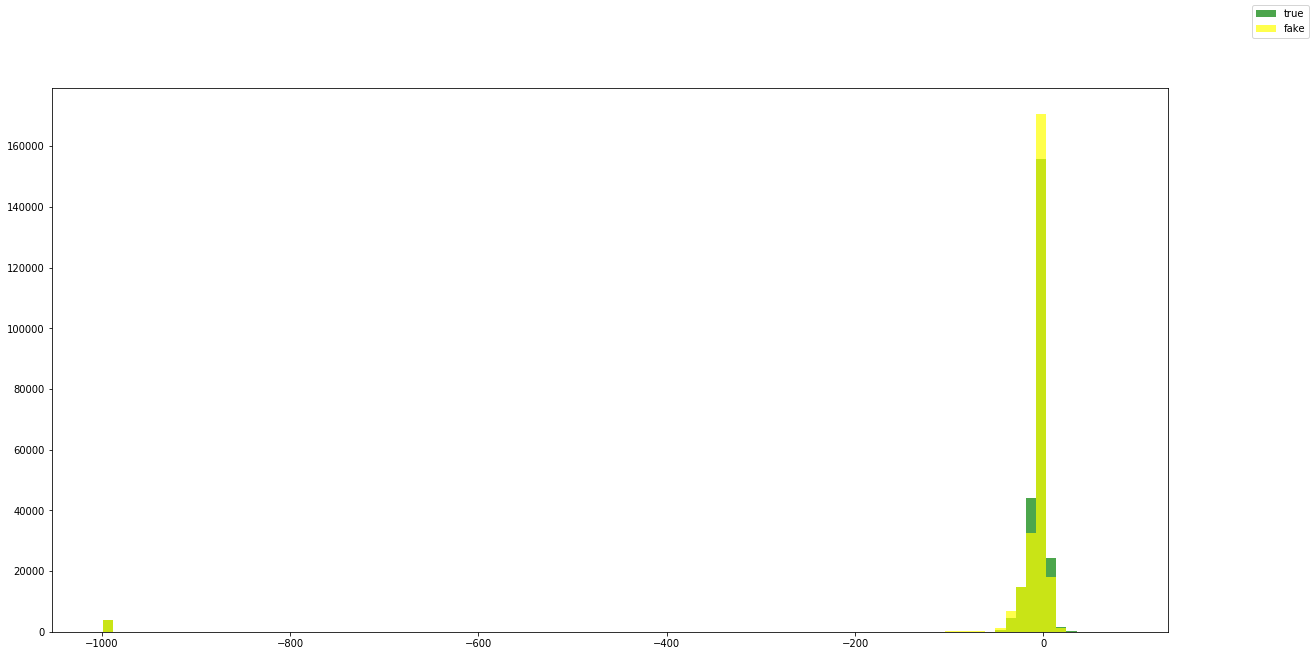

pion :  0.25256997944016446
RichDLLbt


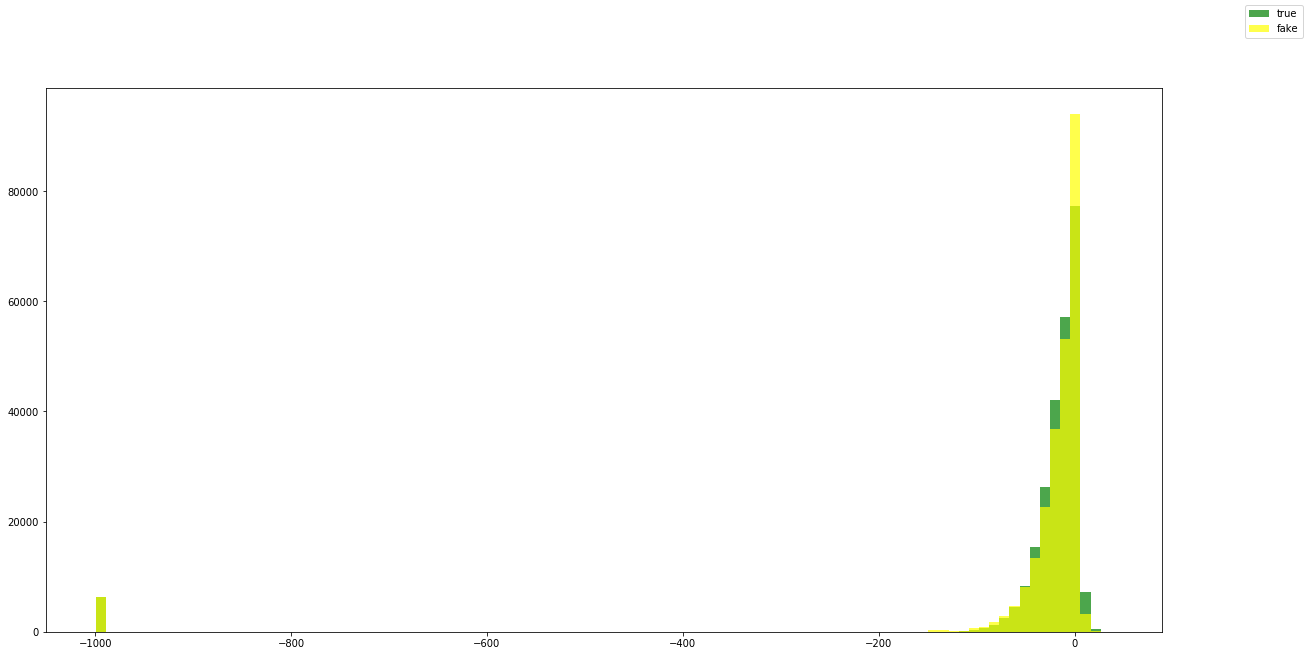

RichDLLk


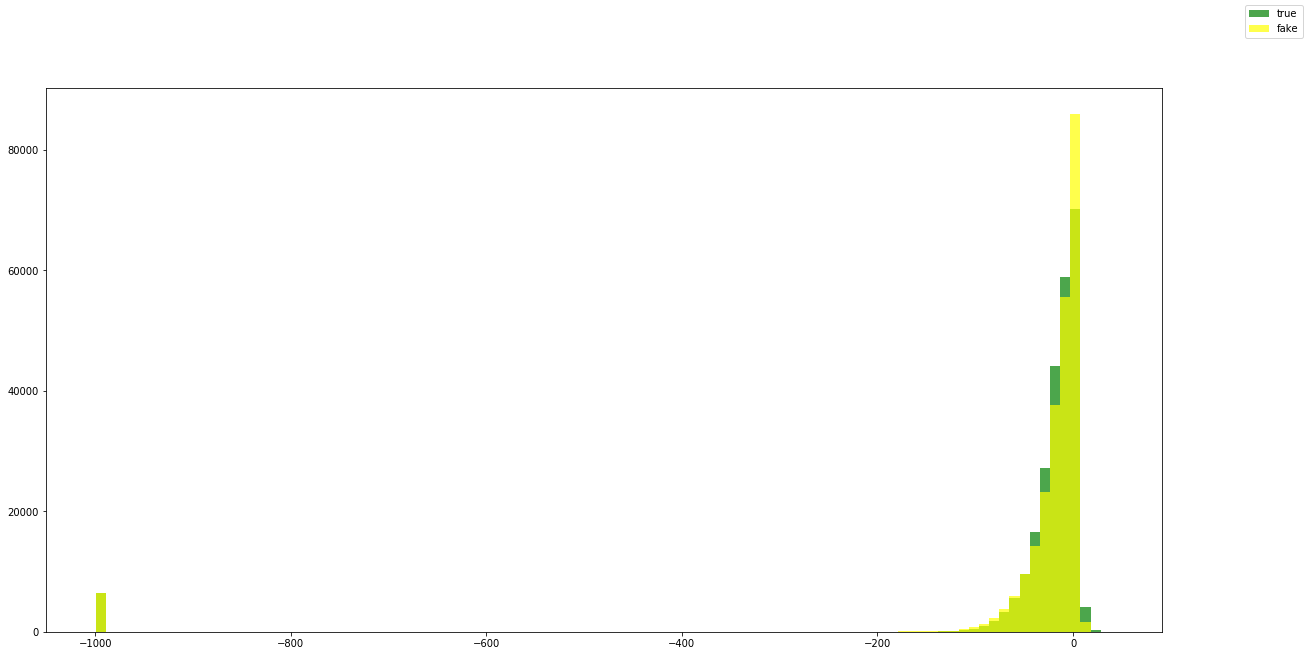

RichDLLmu


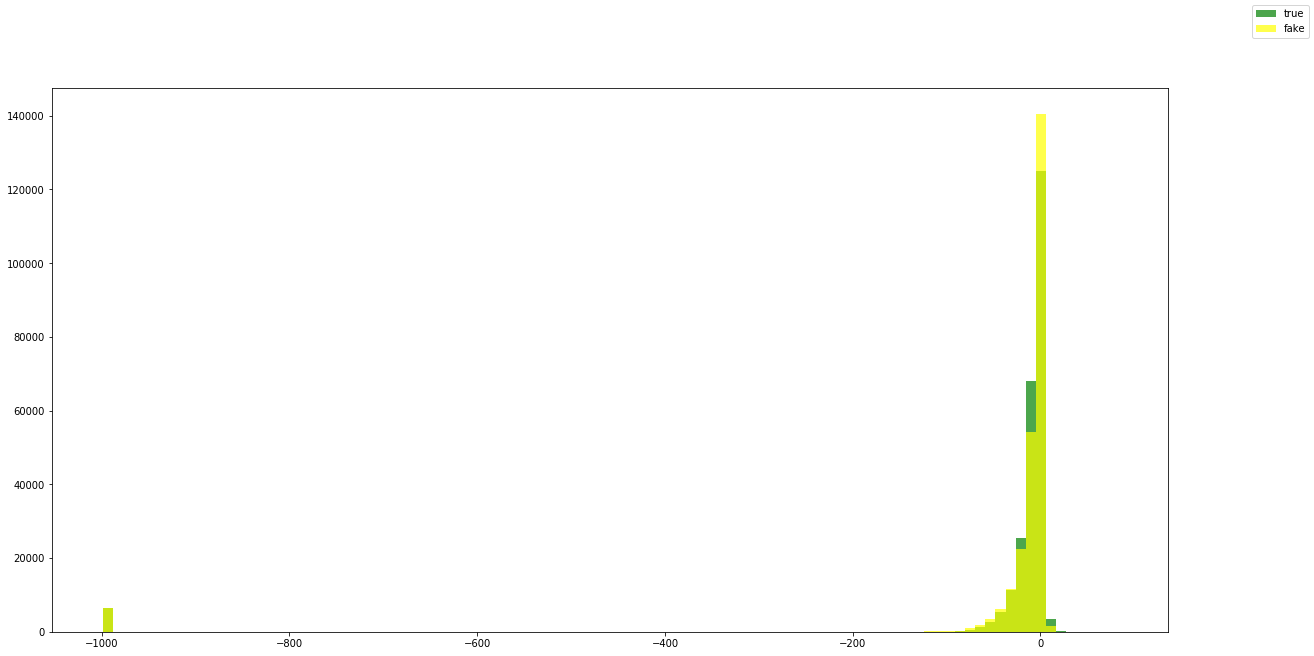

RichDLLp


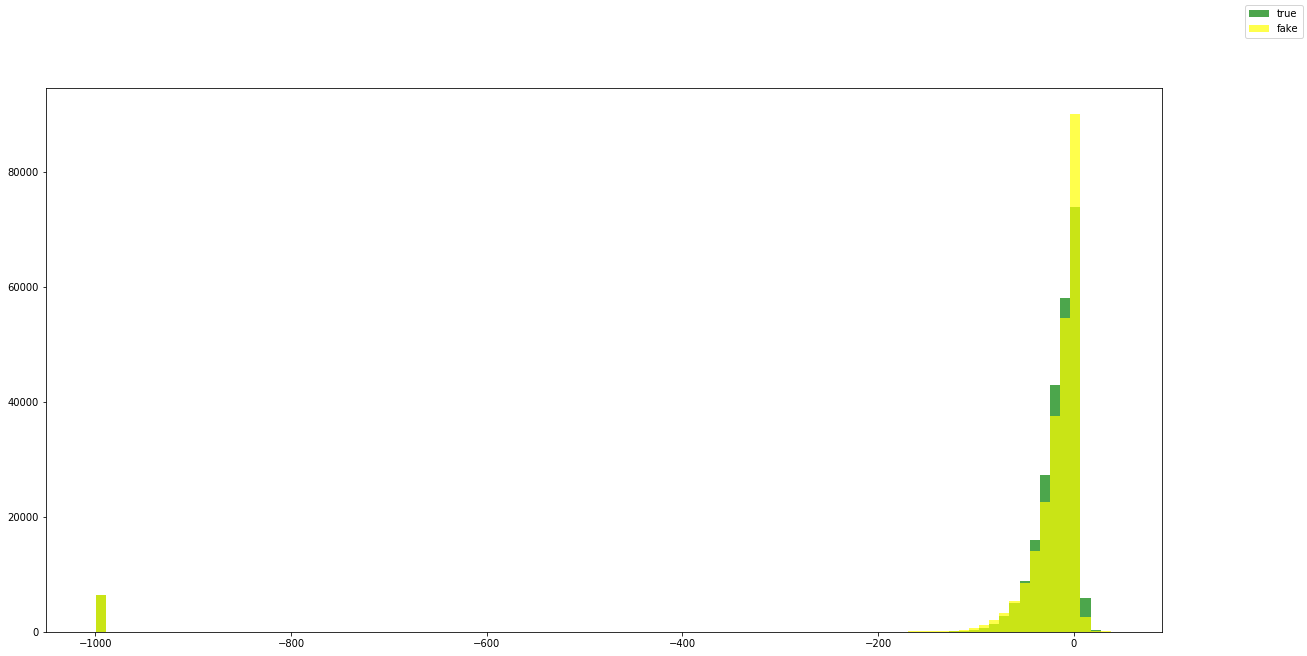

RichDLLe


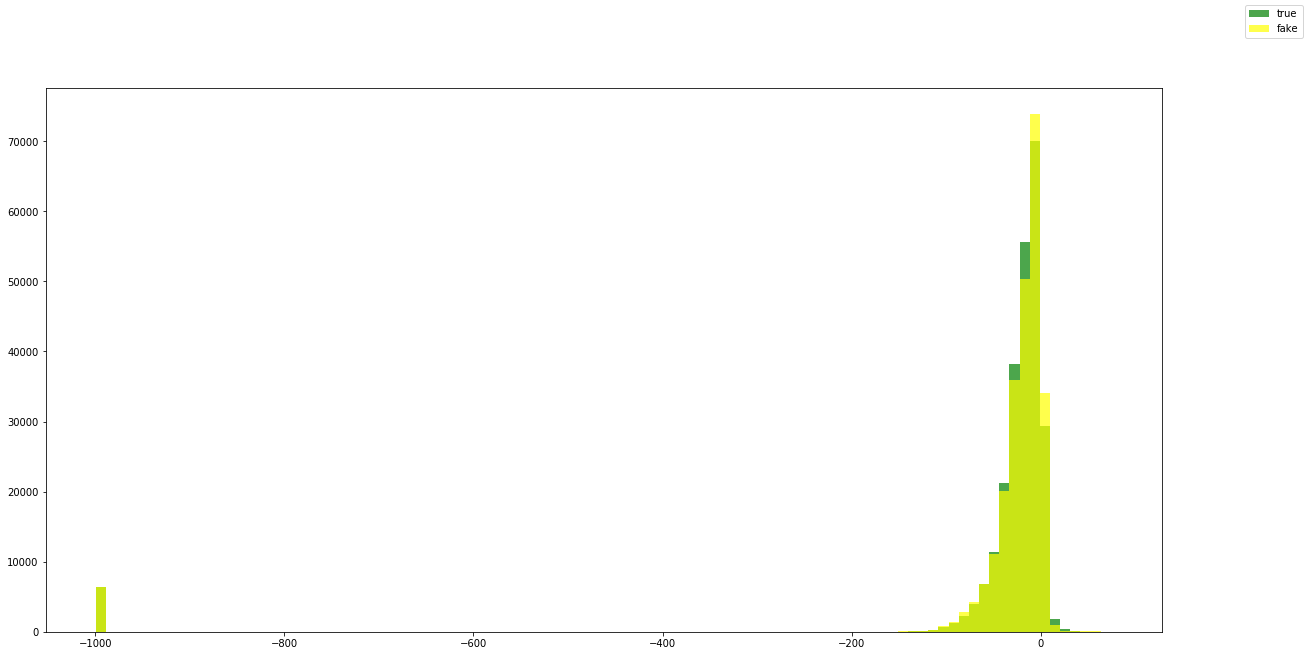

In [5]:
models = dict()
figs = defaultdict(dict)
scores = dict()

for particle in tqdm(['proton', 'muon', 'kaon', 'pion']):
    
    c_train = dataframes[particle]['train'][condition_cols]
    x_train = dataframes[particle]['train'][target_cols]
    c_test = dataframes[particle]['test'][condition_cols]
    x_test = dataframes[particle]['test'][target_cols]
    
    model = get_model()
    model.fit(
        c_train,
        x_train,
        start_epoch=0,
        num_epochs=50,
        n_critic=1,
        batch_size=512,
        writer=SummaryWriter(log_dir=Path(logdir, tag, particle)),
        num_workers=6,
    )
    models[particle] = model
    predicted = model.predict(c_test)
    reference = np.c_[x_test.values, c_test.values]
    generated = np.c_[predicted.values, c_test.values]
    score = score_func(generated, reference, n_slices=1000)
    scores[particle] = score
    print(particle, ': ', score)
    for col in target_cols:
        print(col)
        fig = plot_hist(x_test[col].values, predicted[col].values)
        figs[particle][col] = fig
        display(fig)
    print('='*100)
        

proton :  0.17114283279013232
RichDLLbt


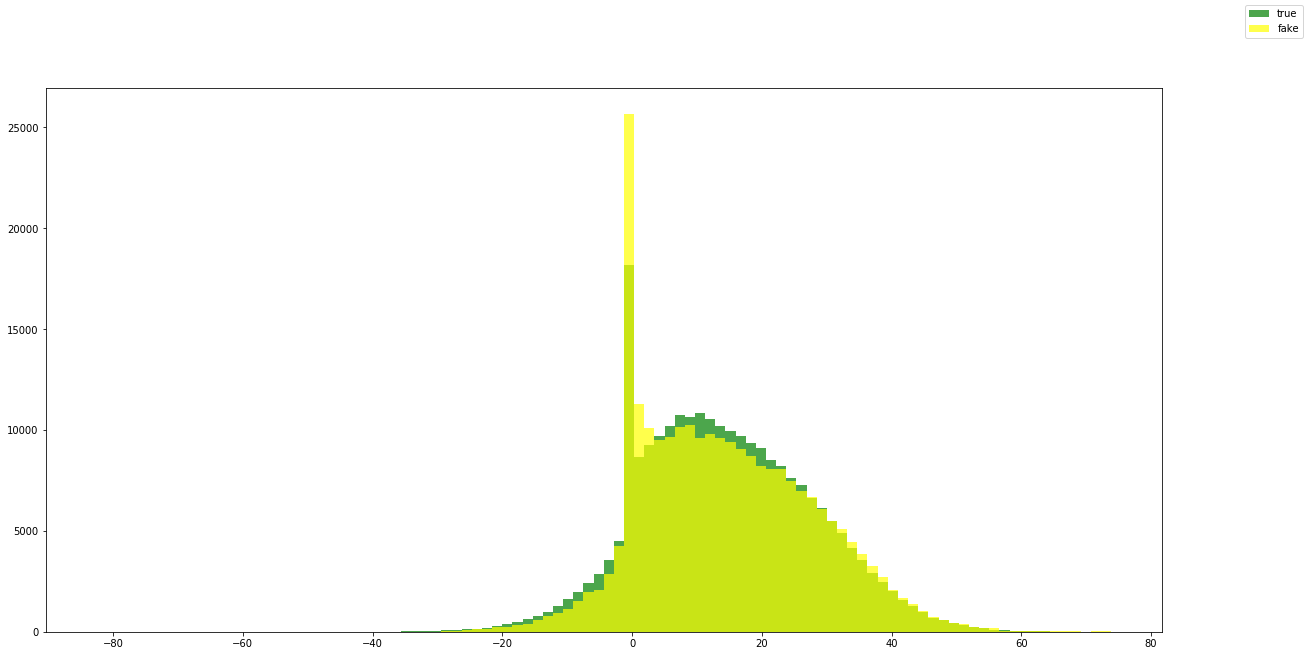

RichDLLk


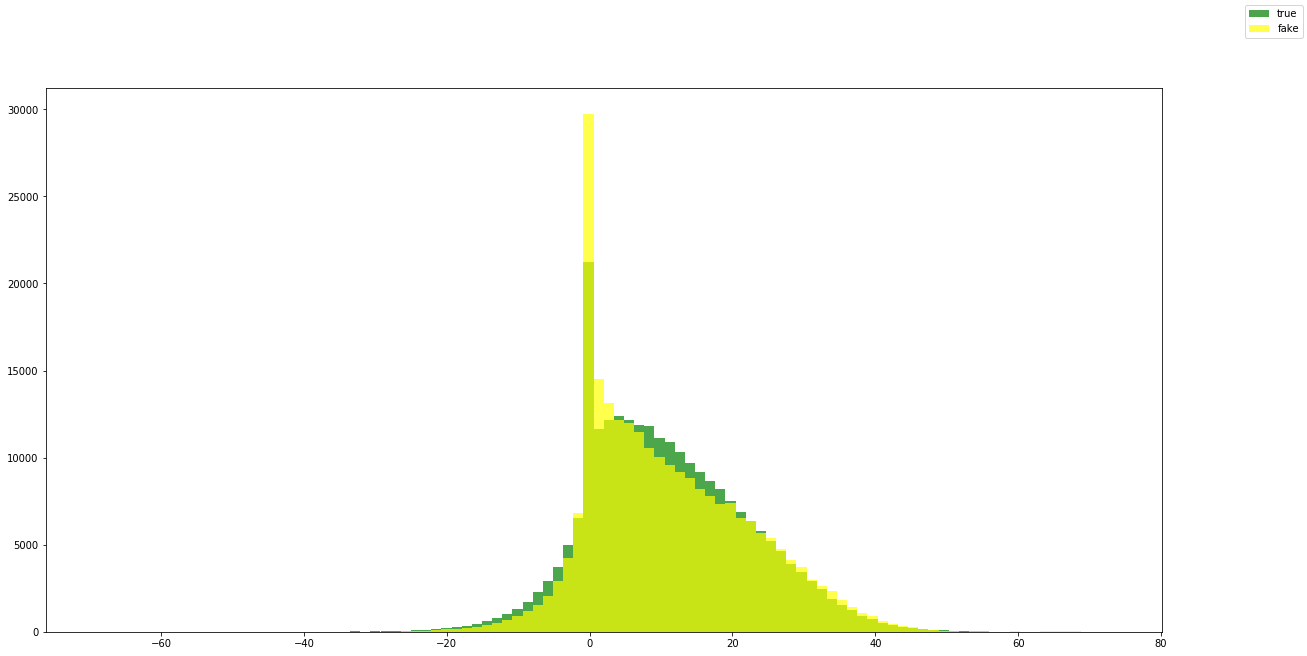

RichDLLmu


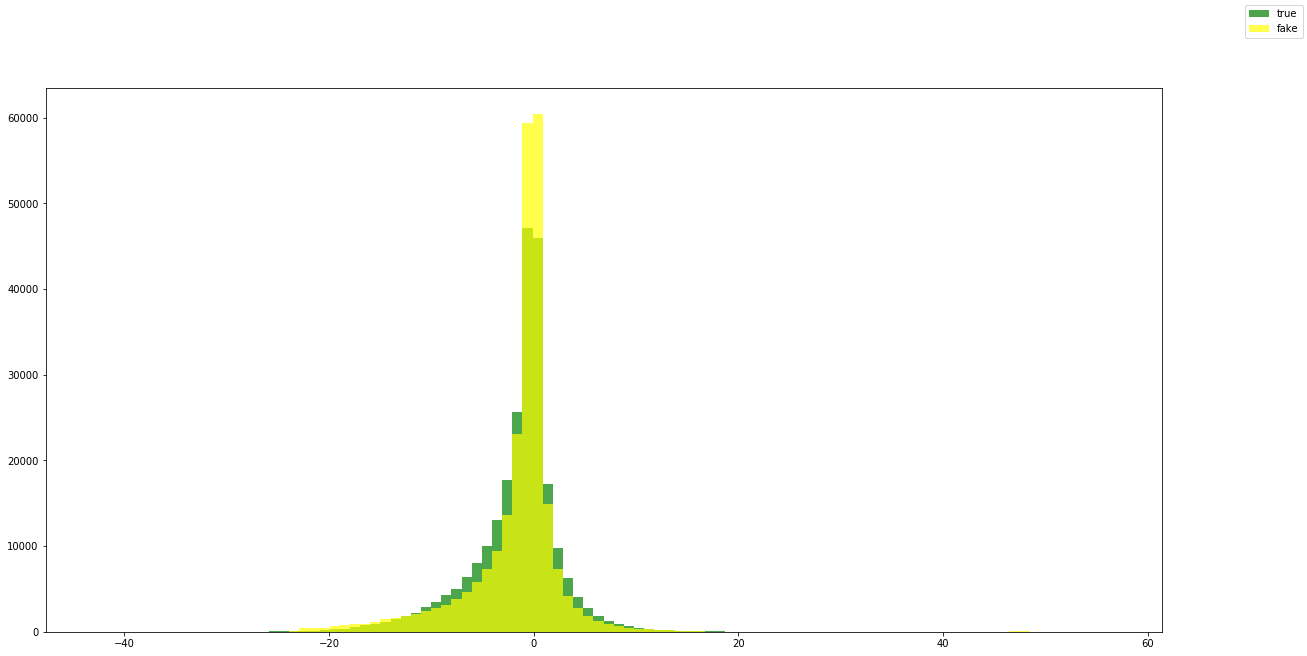

RichDLLp


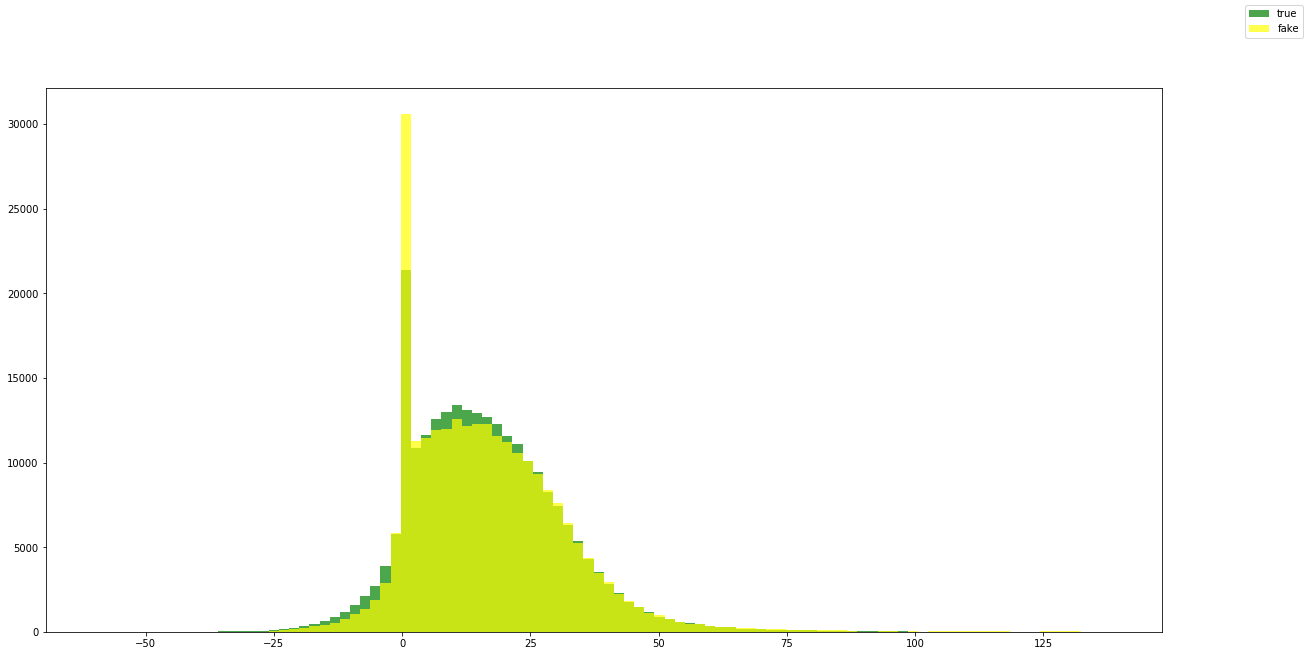

RichDLLe


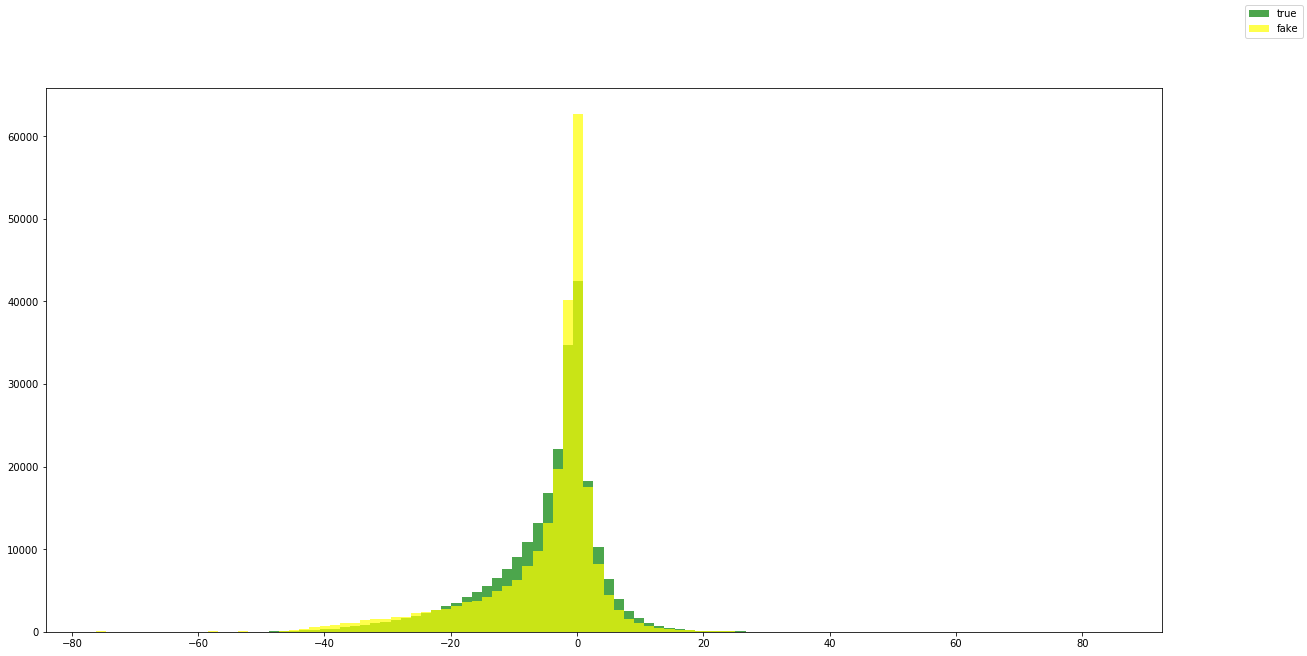

muon :  0.18502363514637565
RichDLLbt


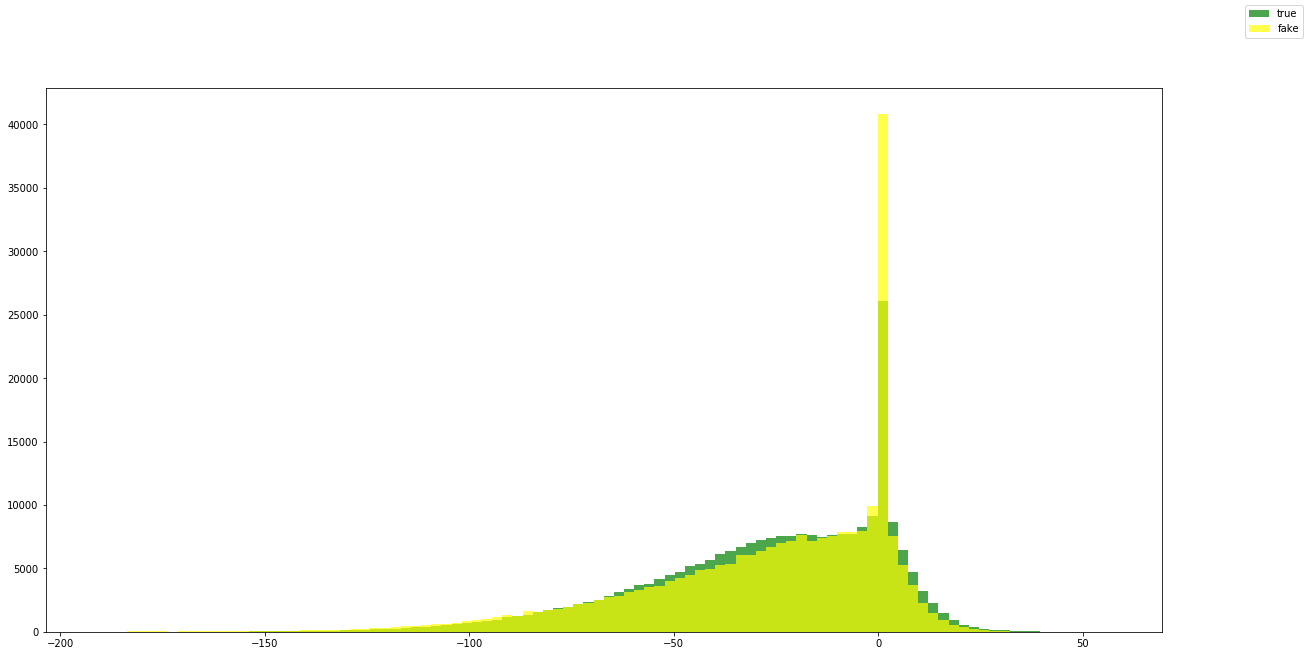

RichDLLk


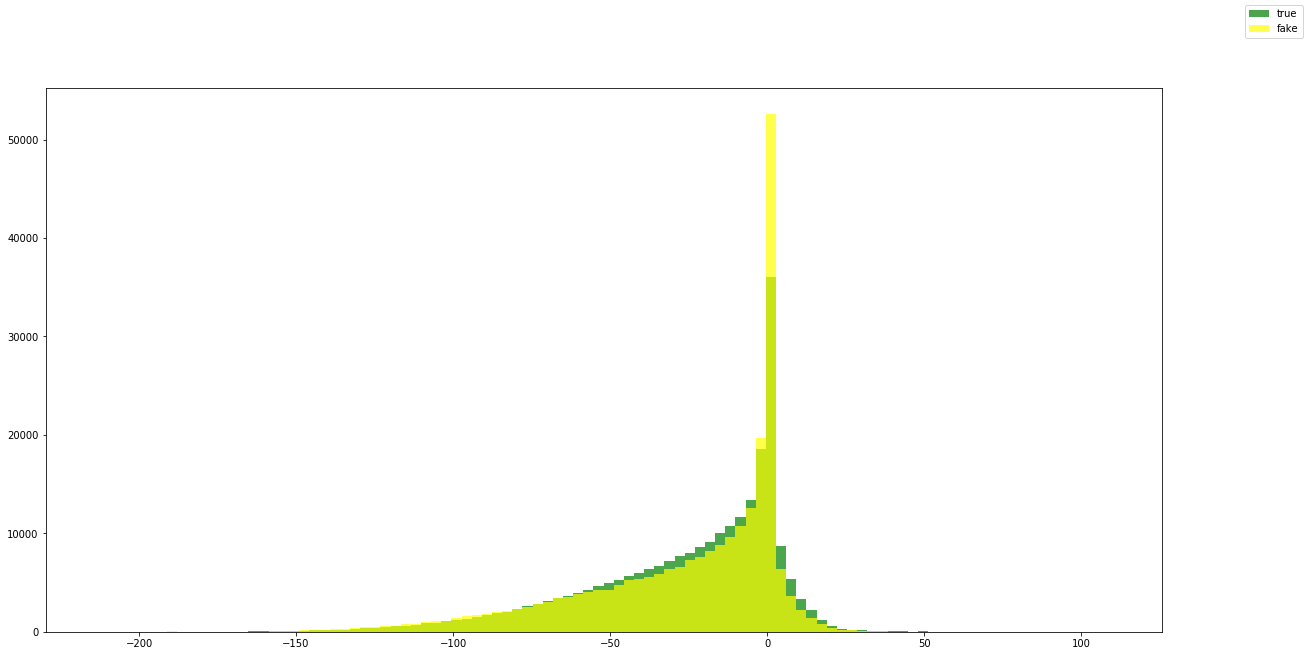

RichDLLmu


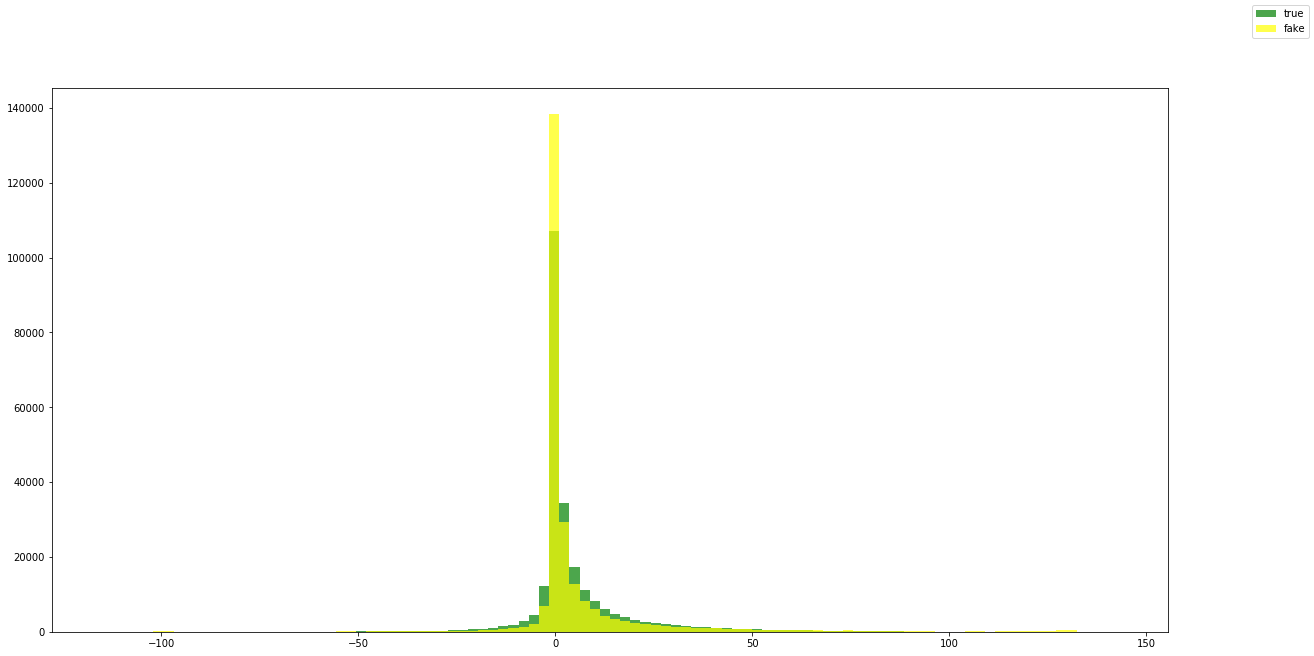

RichDLLp


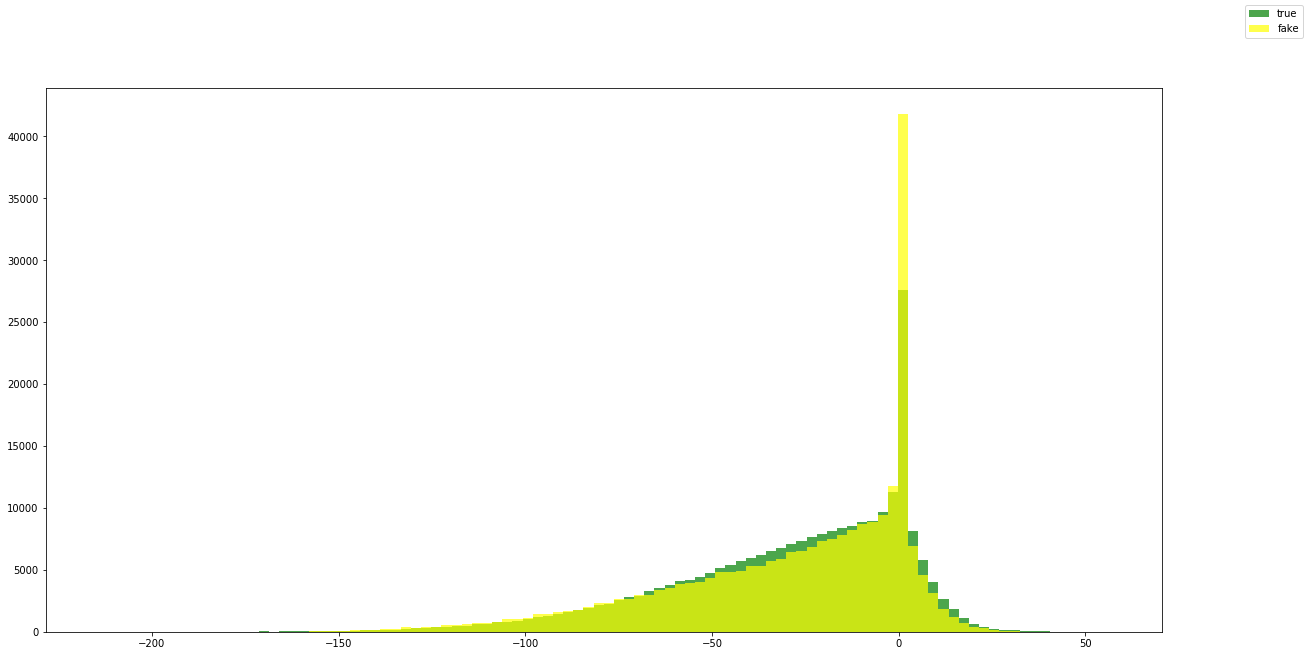

RichDLLe


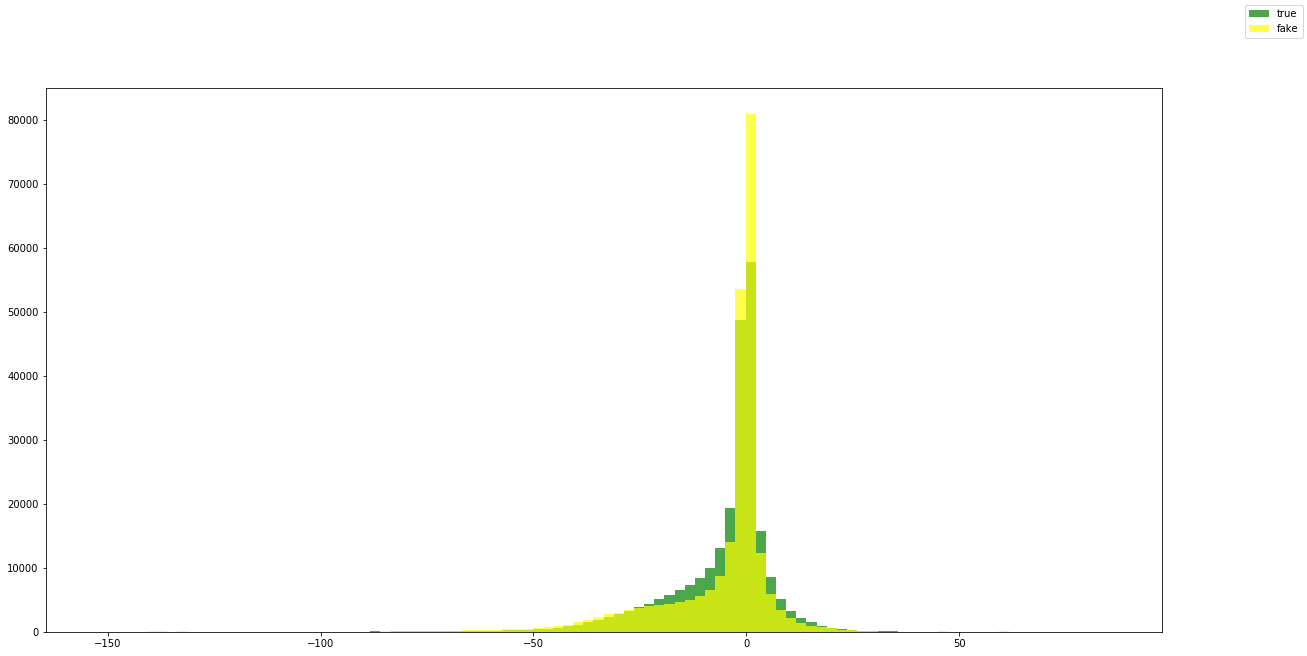

kaon :  0.16536434524317445
RichDLLbt


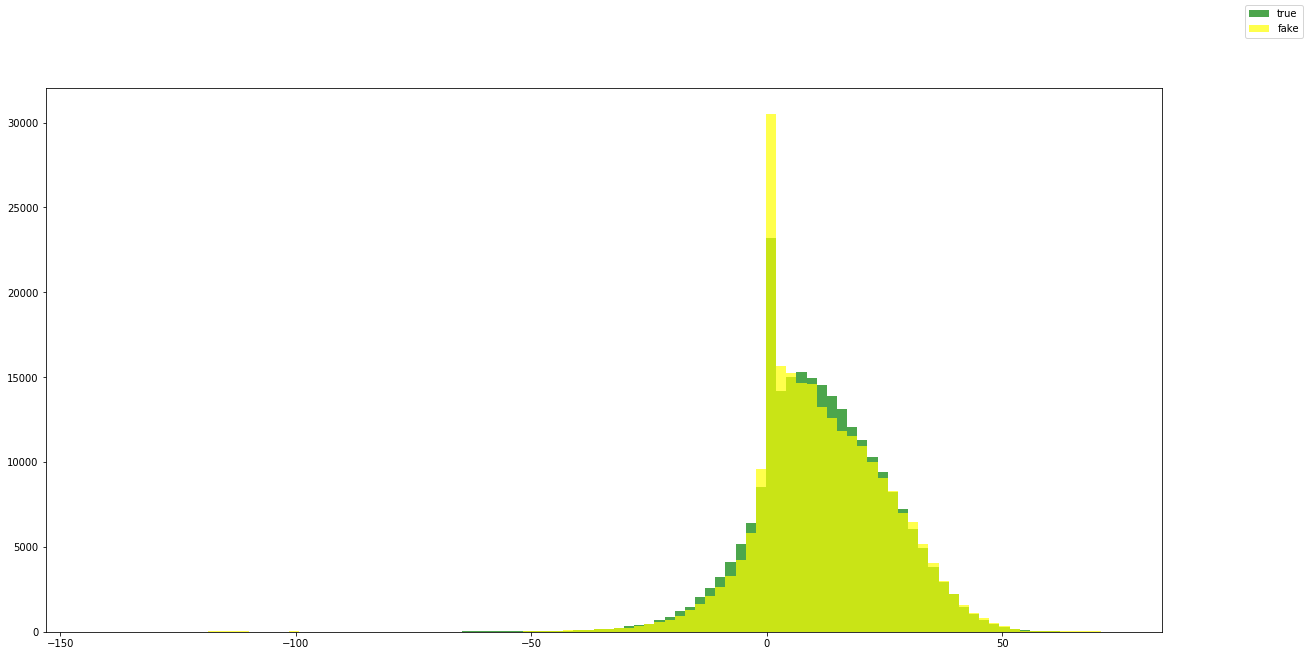

RichDLLk


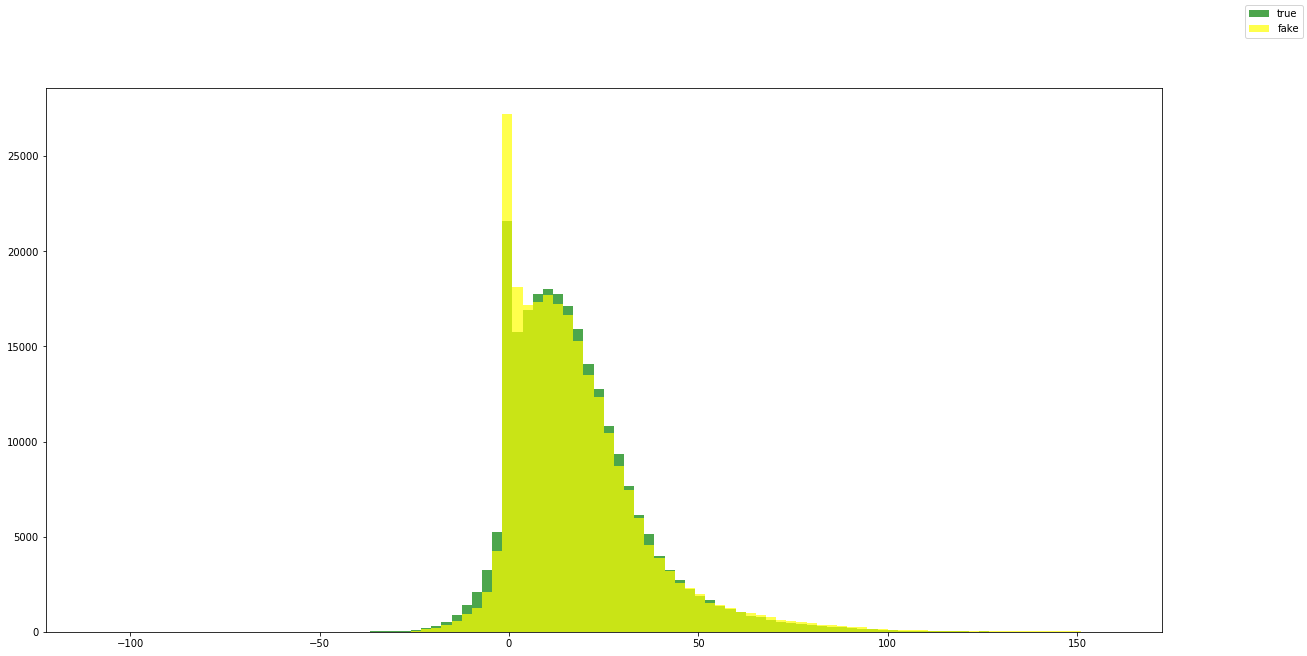

RichDLLmu


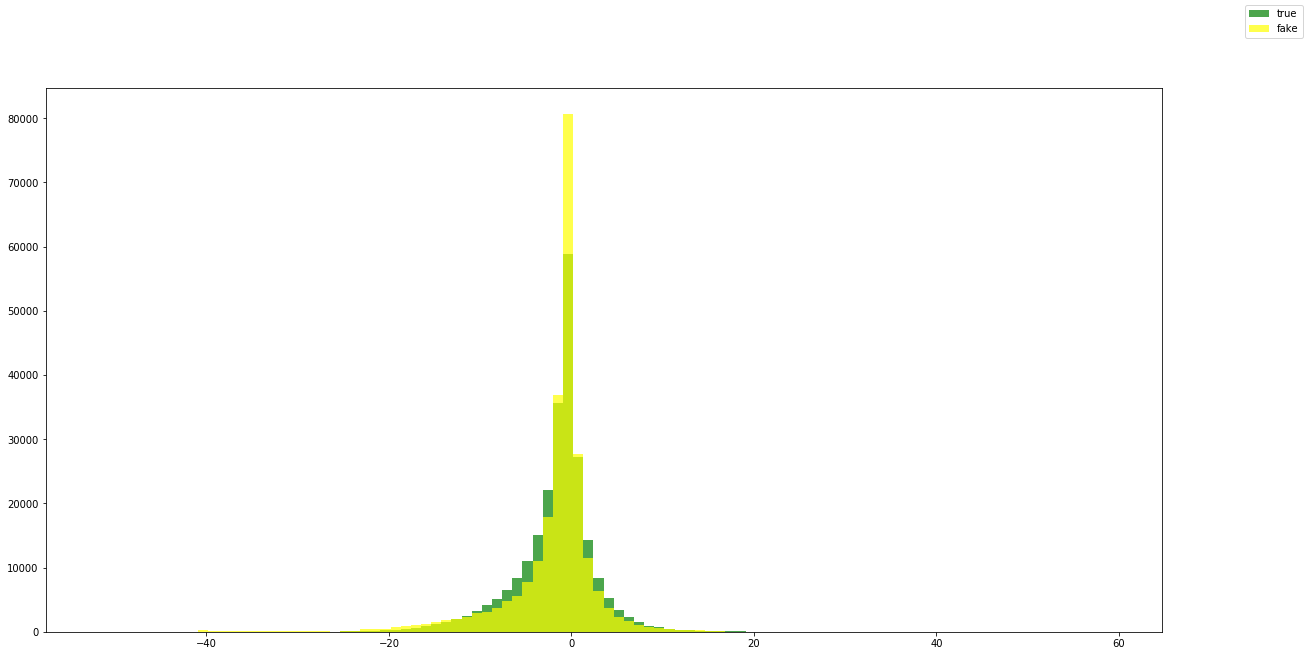

RichDLLp


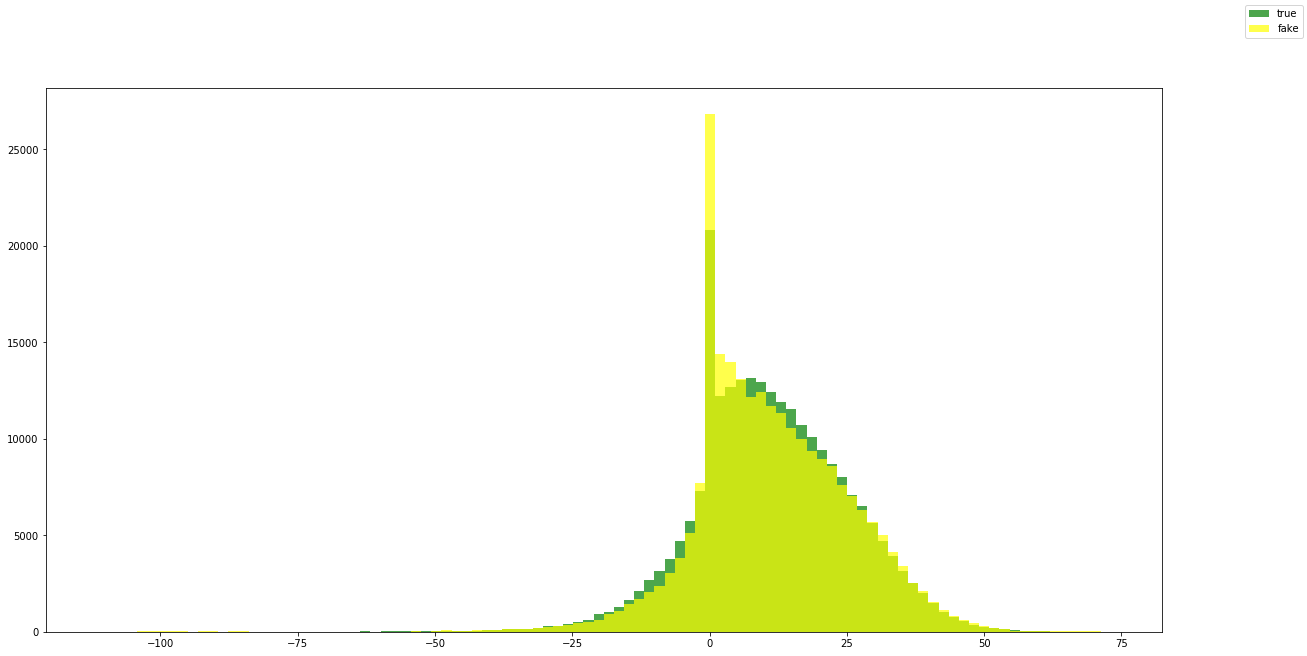

RichDLLe


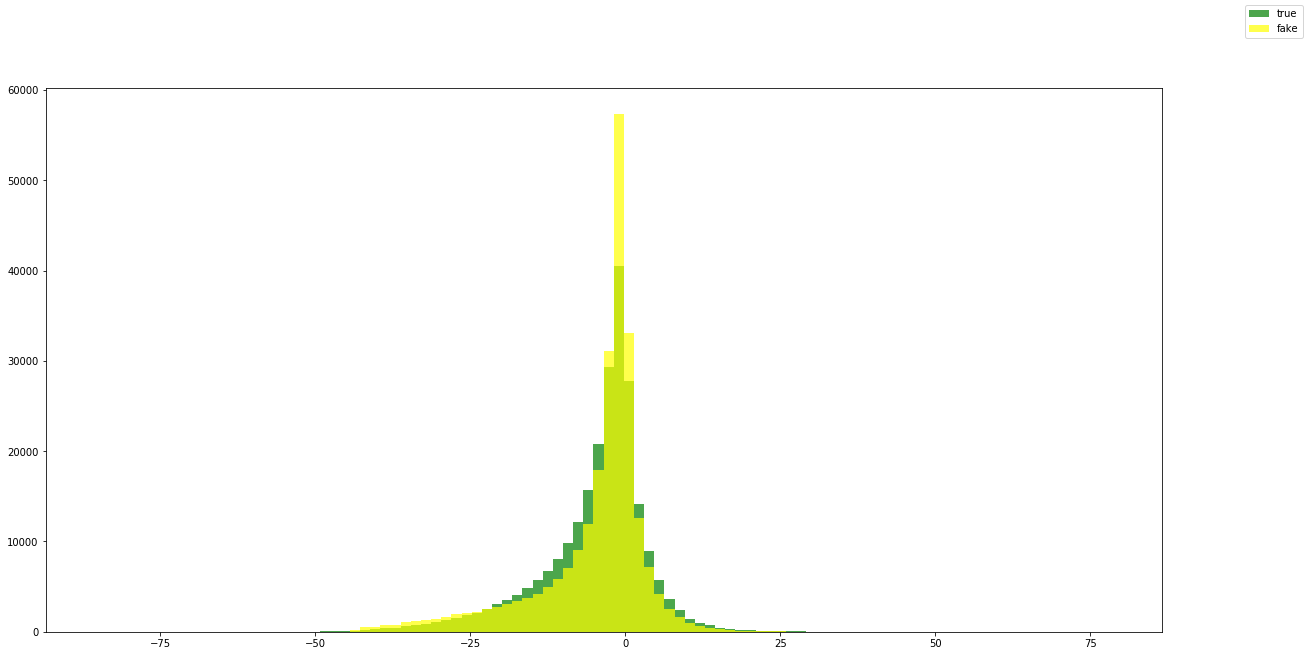

pion :  0.2633374384236453
RichDLLbt


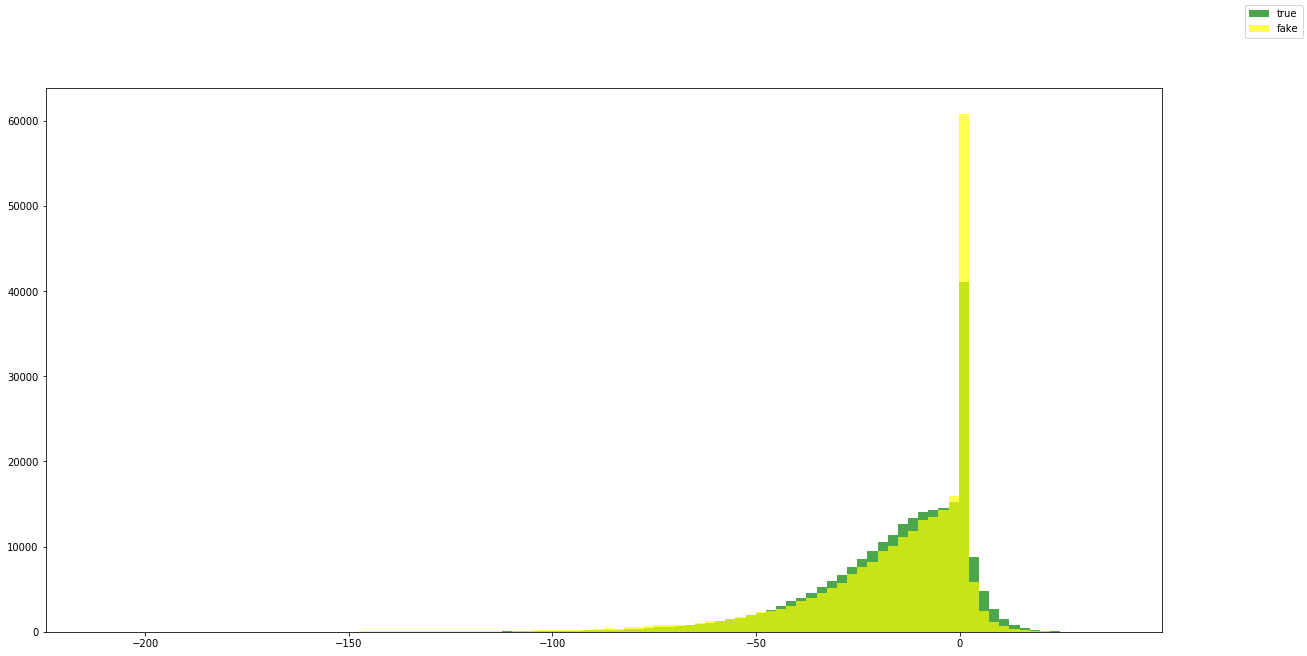

RichDLLk


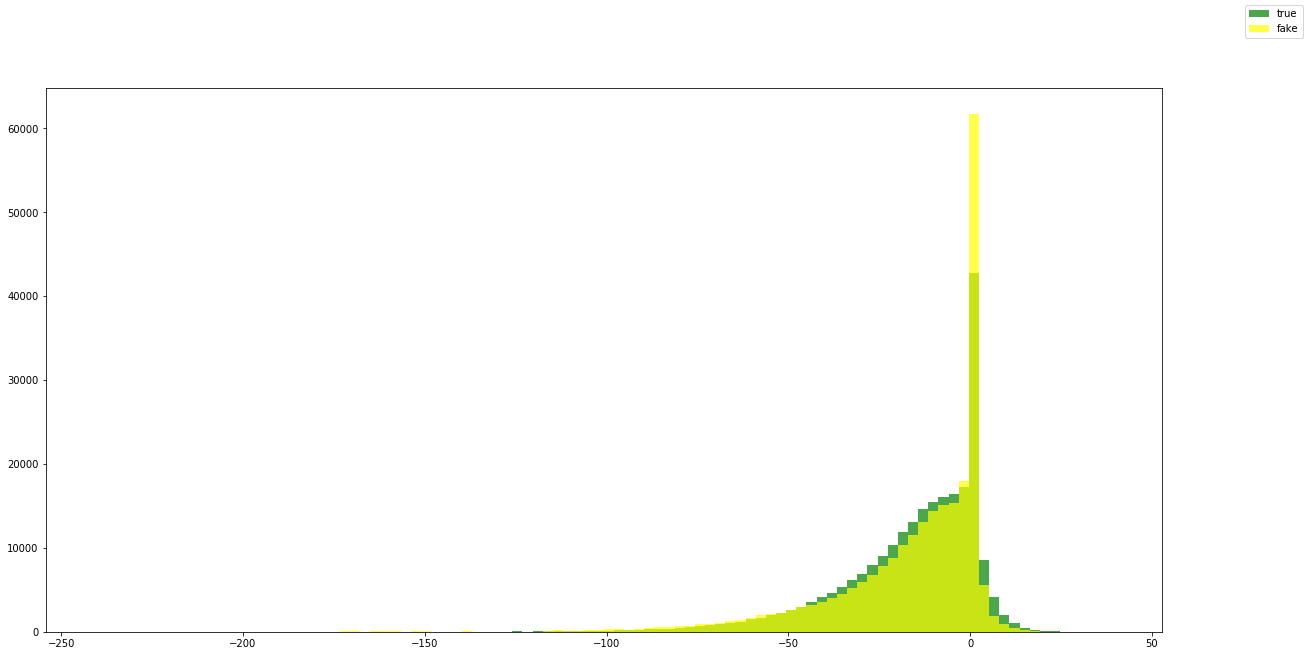

RichDLLmu


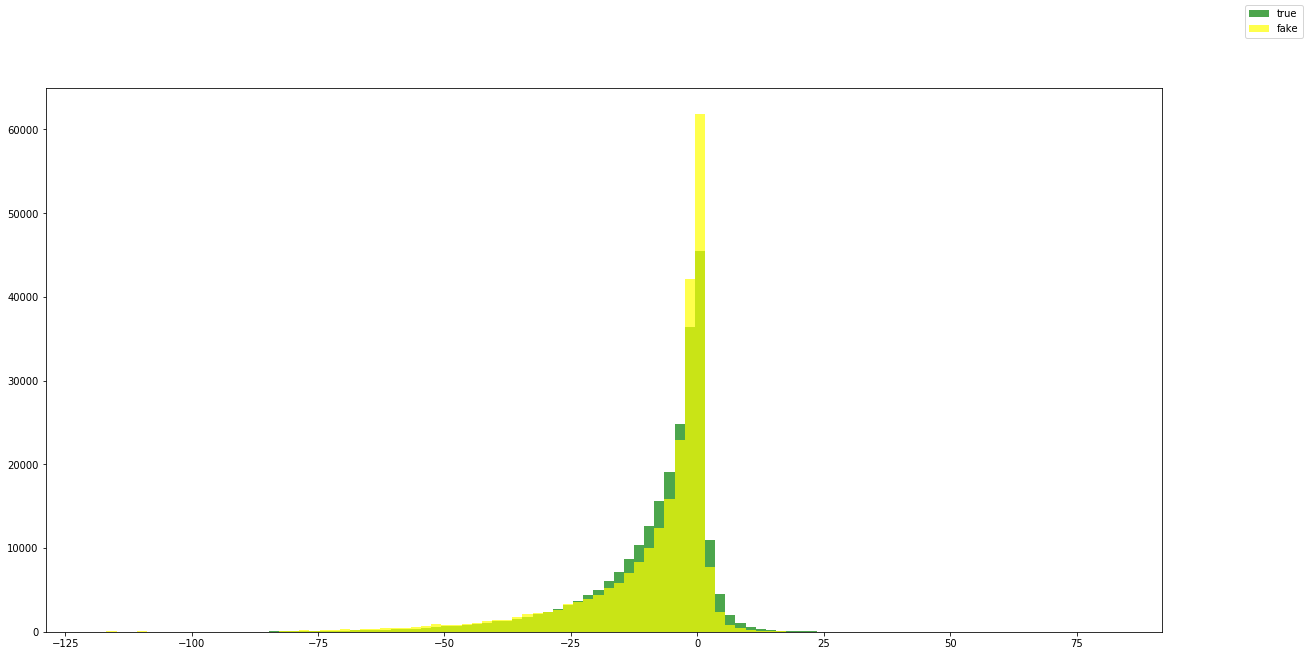

RichDLLp


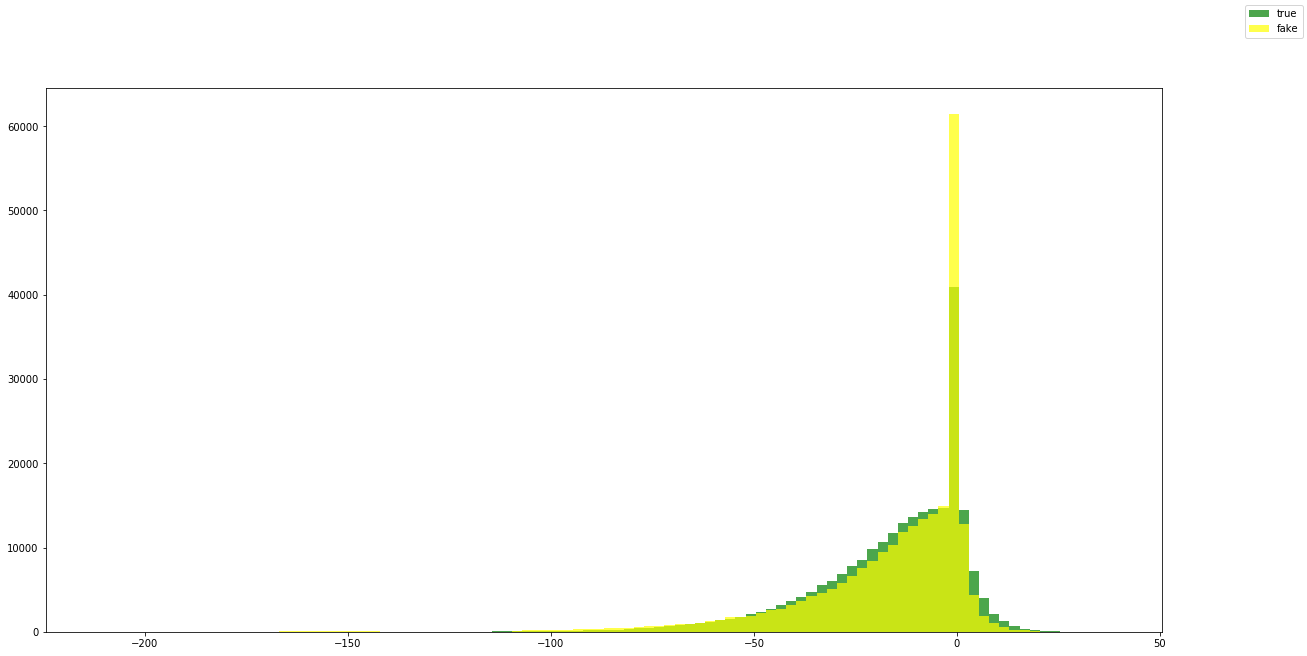

RichDLLe


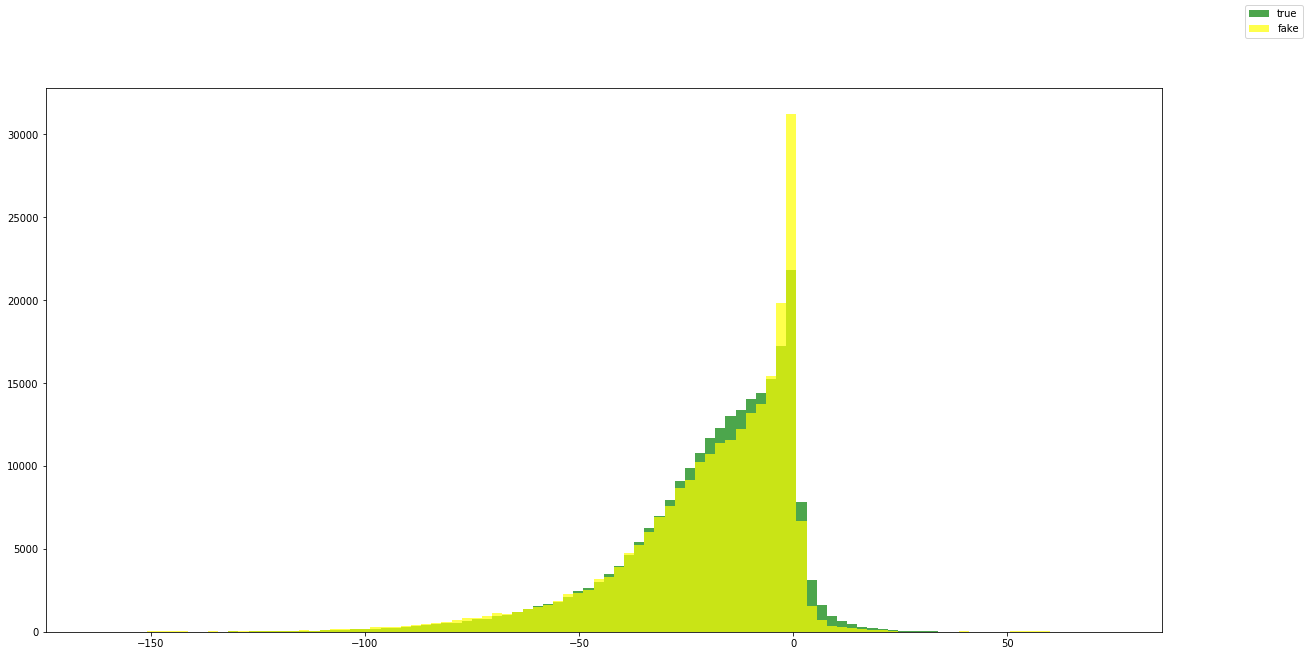

In [17]:
figs_filtered = defaultdict(dict)
scores_filtered = dict()
for particle in tqdm(['proton', 'muon', 'kaon', 'pion']):
    
    c_test = dataframes[particle]['test'][condition_cols]
    x_test = dataframes[particle]['test'][target_cols]
    mask1 = (x_test == -999).values.all(axis=1)
    mask2 = (x_test == 0).values.all(axis=1)
    mask = (mask1 | mask2)
    c_test = c_test[~mask]
    x_test = x_test[~mask]
    model = models[particle]
    model.simulate_error_codes = False
    predicted = model.predict(c_test)
    reference = np.c_[x_test.values, c_test.values]
    generated = np.c_[predicted.values, c_test.values]
    score = score_func(generated, reference, n_slices=1000)
    scores_filtered[particle] = score
    print(particle, ': ', score)
    for col in target_cols:
        print(col)
        fig = plot_hist(x_test[col].values, predicted[col].values)
        figs_filtered[particle][col] = fig
        display(fig)
    print('='*100)
        

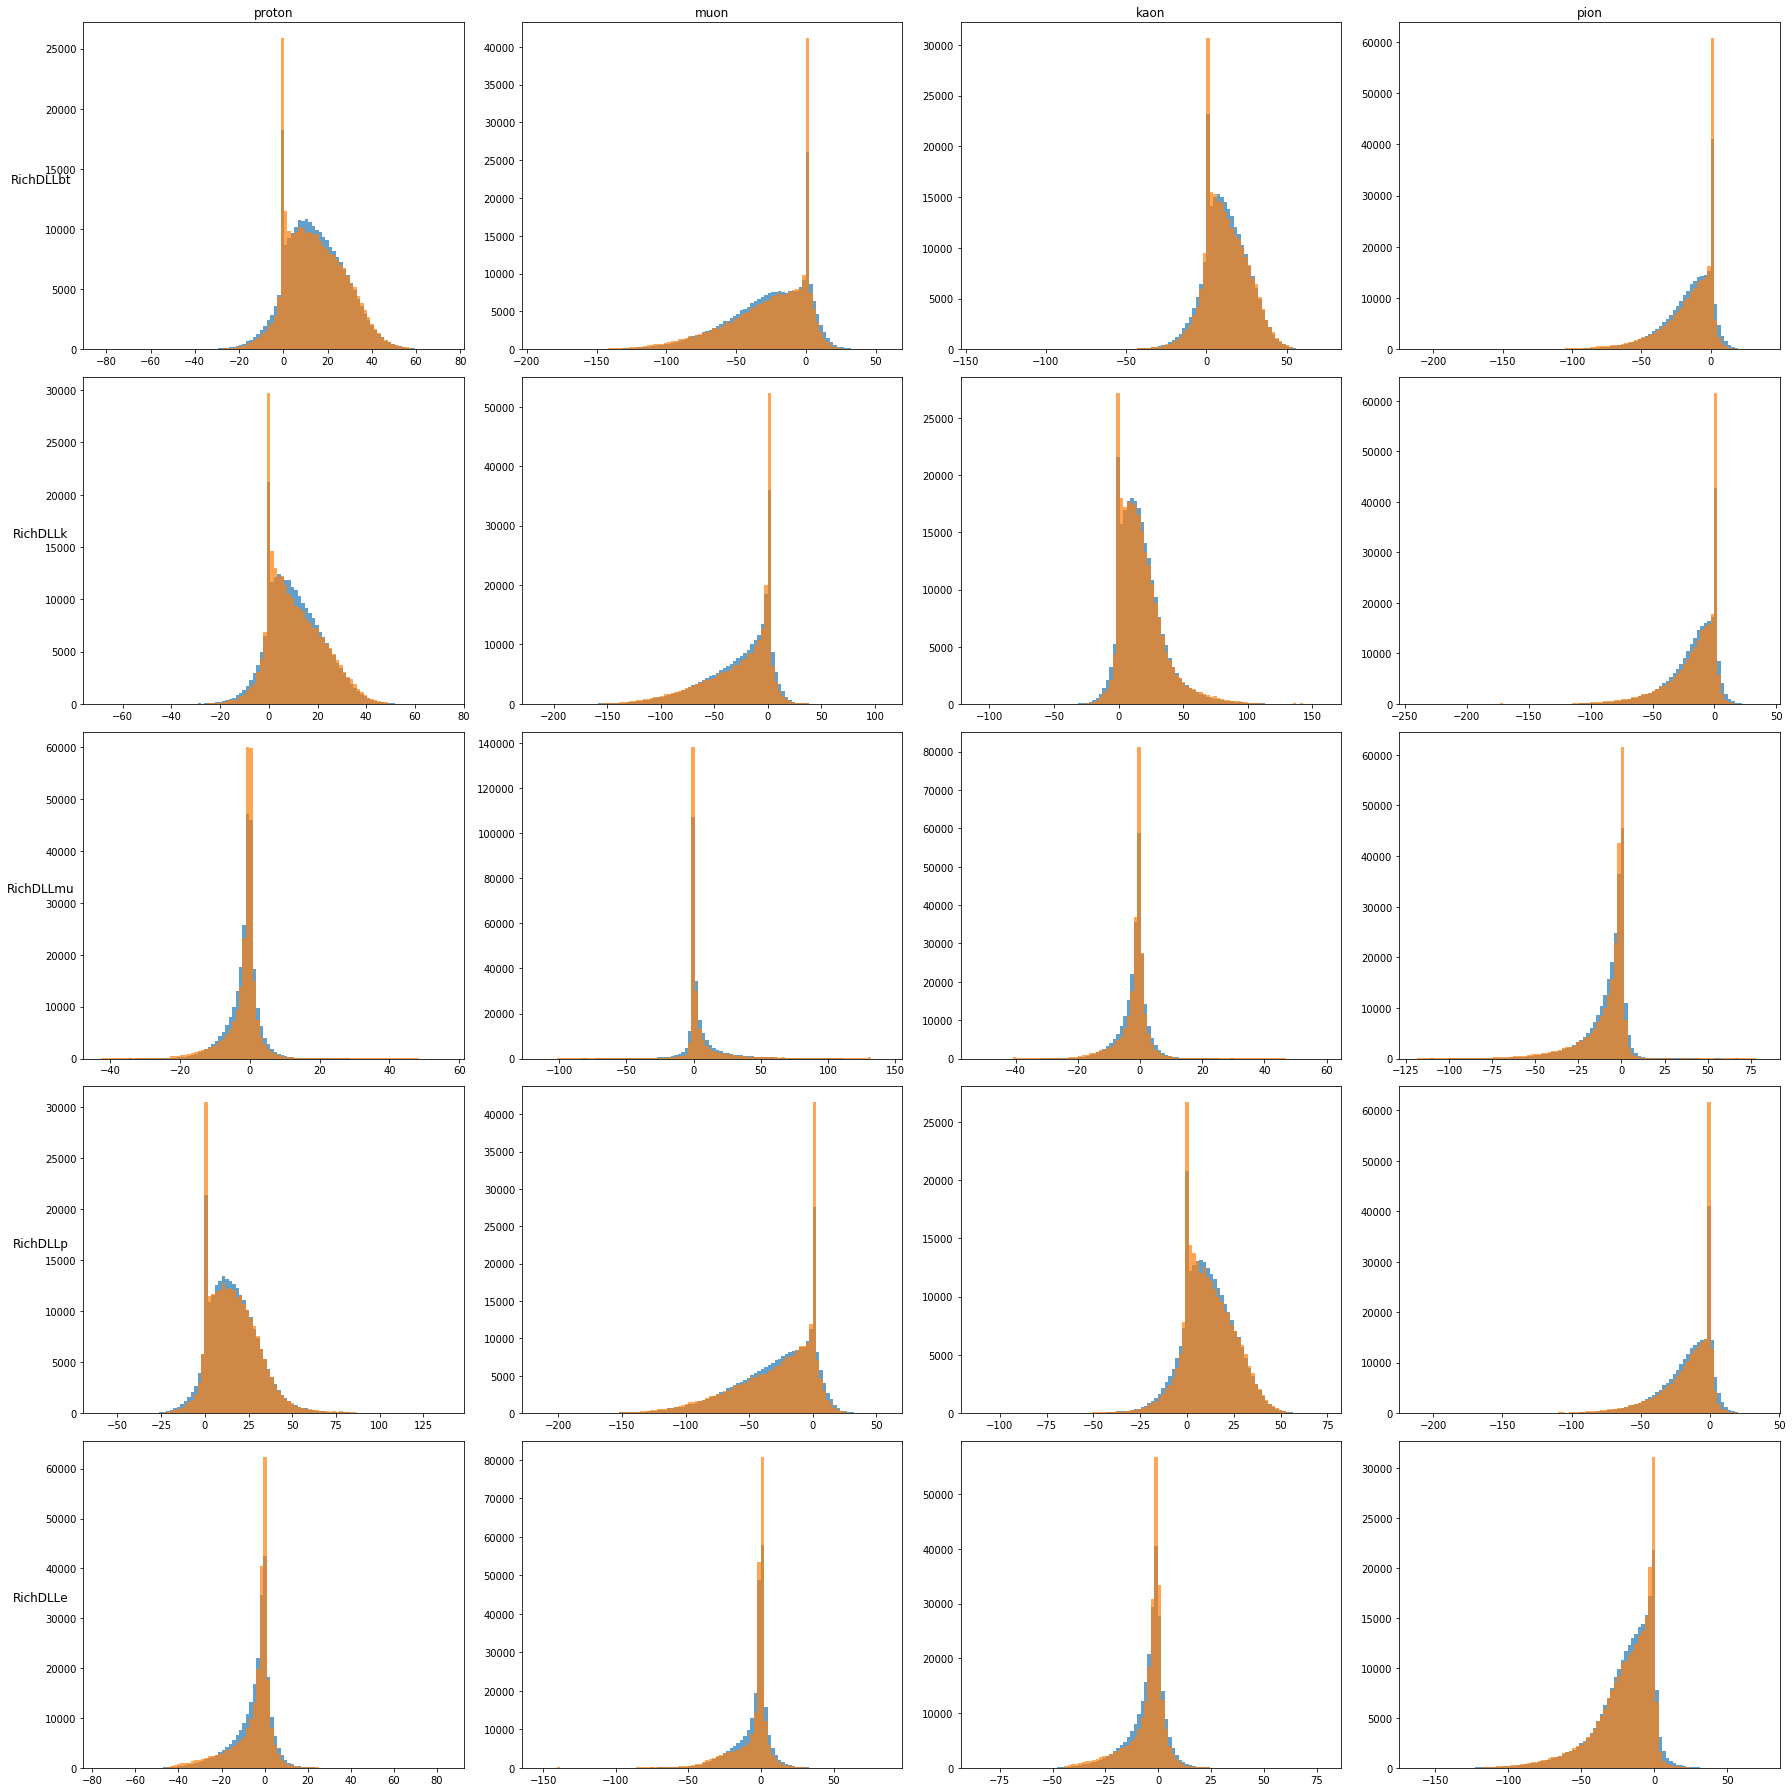

In [41]:
fig, axes = plt.subplots(ncols=4, nrows=len(target_cols), figsize=(25,25))
for j, particle in enumerate(tqdm(['proton', 'muon', 'kaon', 'pion'])):
    
    c_test = dataframes[particle]['test'][condition_cols]
    x_test = dataframes[particle]['test'][target_cols]
    mask1 = (x_test == -999).values.all(axis=1)
    mask2 = (x_test == 0).values.all(axis=1)
    mask = (mask1 | mask2)
    c_test = c_test[~mask]
    x_test = x_test[~mask]
    model = models[particle]
    model.simulate_error_codes = False
    predicted = model.predict(c_test)
    for i, col in enumerate(target_cols):
        _, bins, _ = axes[i][j].hist(x_test[col].values, bins=100, alpha=0.7)
        axes[i][j].hist(predicted[col].values, bins=bins, alpha=0.7)
for ax, col in zip(axes[0], ['proton', 'muon', 'kaon', 'pion']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], target_cols):
    ax.set_ylabel(row,rotation=0, size='large')
fig.tight_layout()
fig.savefig(f'/_data/pics/bin_preds.png', format='png')

In [ ]:
f

In [22]:
[round(x, 3) for x in scores_filtered.values()]

[0.171, 0.185, 0.165, 0.263]

In [8]:
scores_filtered

{'proton': 0.17114283279013232,
 'muon': 0.18502363514637565,
 'kaon': 0.16536434524317445,
 'pion': 0.2633374384236453}

In [9]:
figs['kaon']['RichDLLbt'].savefig

<bound method Figure.savefig of <Figure size 1440x720 with 1 Axes>>

In [10]:
for particle in figs:
    for col in figs[particle]:
        p = Path(f'/_data/richgan/pics/{tag}', particle)
        p.mkdir(parents=True, exist_ok=True)
        figs[particle][col].savefig(Path(p, col).with_suffix('.png').as_posix(), format='png')

In [16]:
for particle in figs_filtered:
    for col in figs_filtered[particle]:
        p = Path(f'/_data/richgan/pics/{tag}/', particle)
        p.mkdir(parents=True, exist_ok=True)
        figs_filtered[particle][col].savefig(Path(p, f'{col}-filtered').with_suffix('.png').as_posix(), format='png')

proton :  0.18348473393893572
RichDLLbt


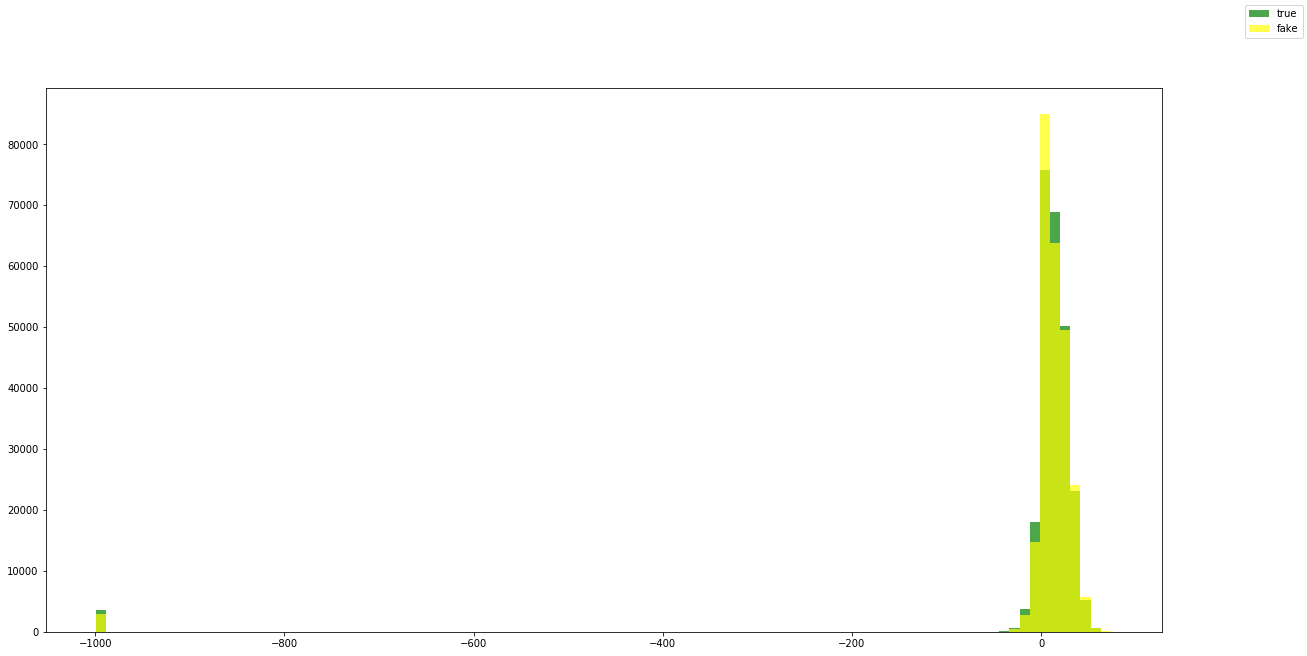

RichDLLk


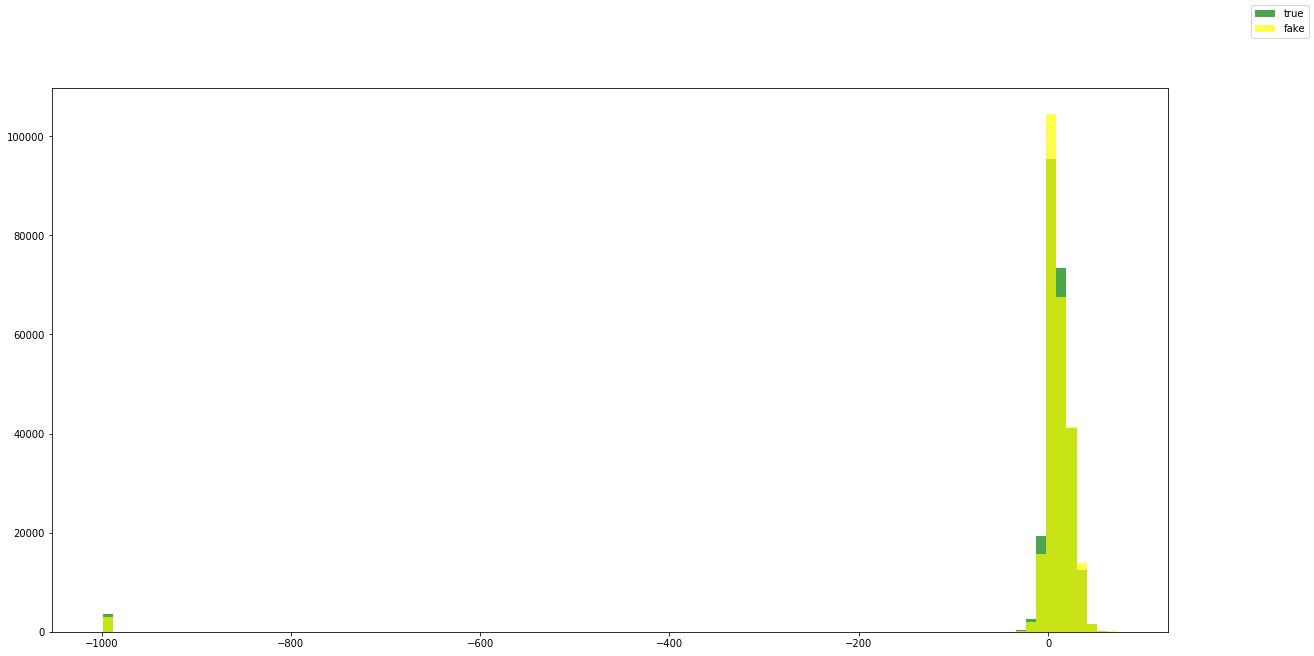

RichDLLmu


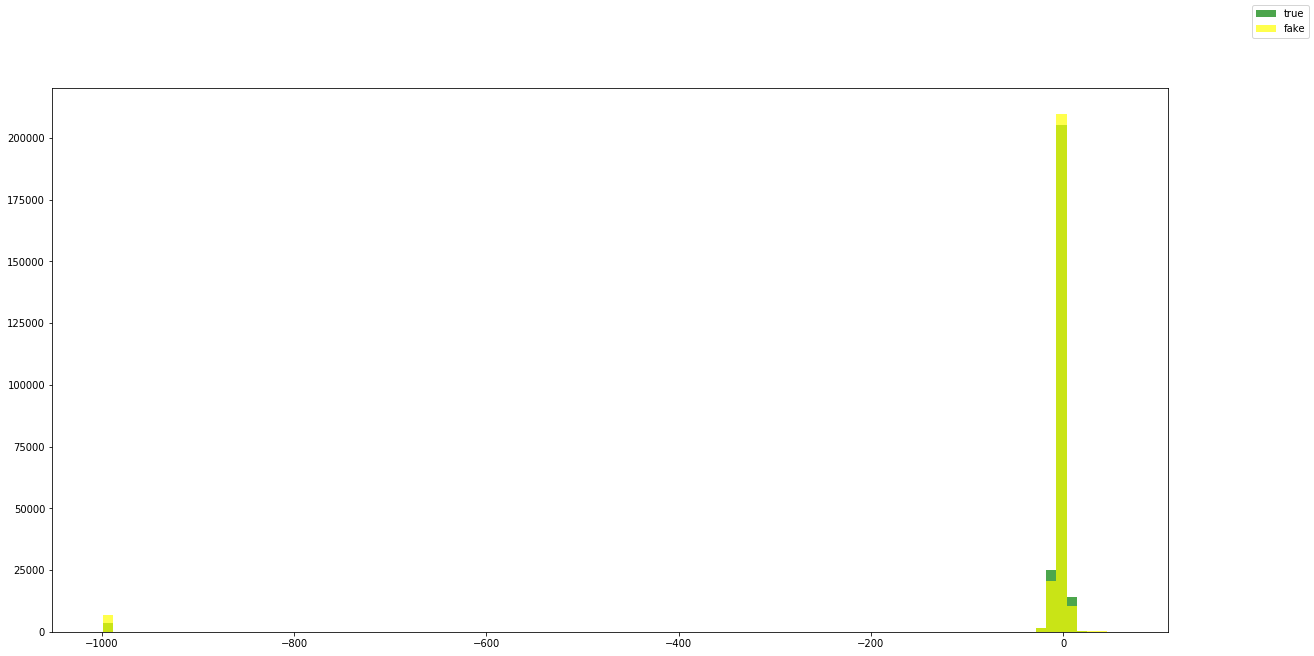

RichDLLp


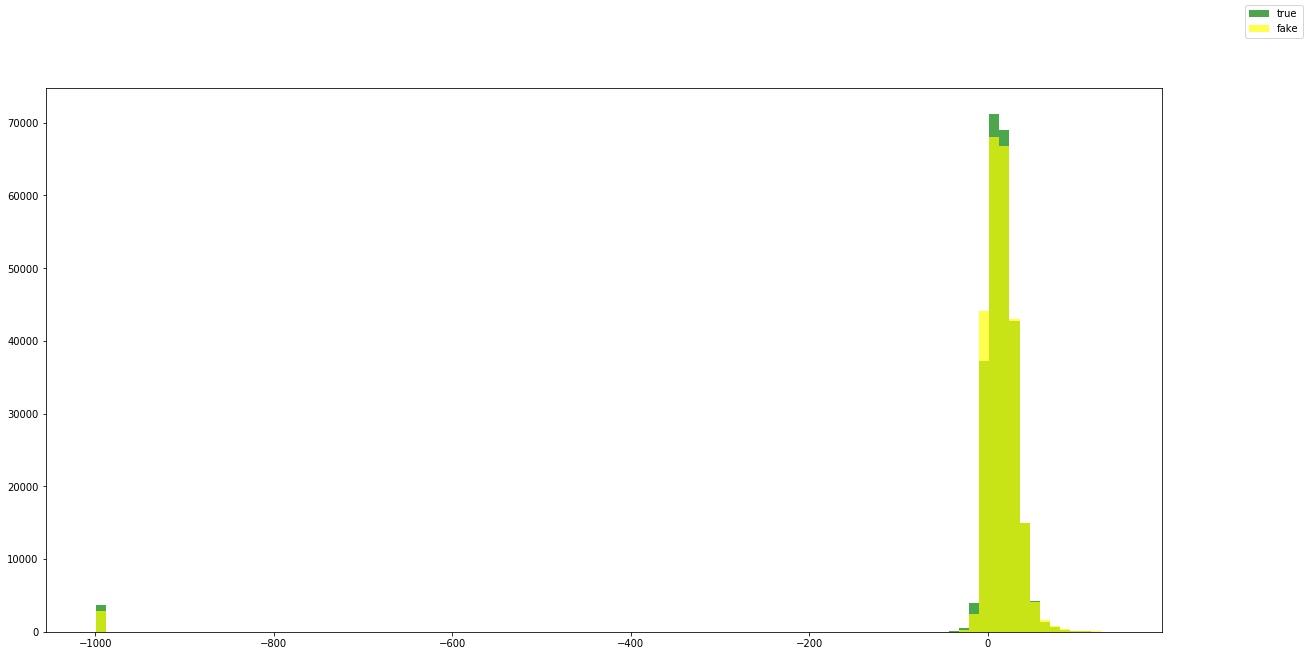

RichDLLe


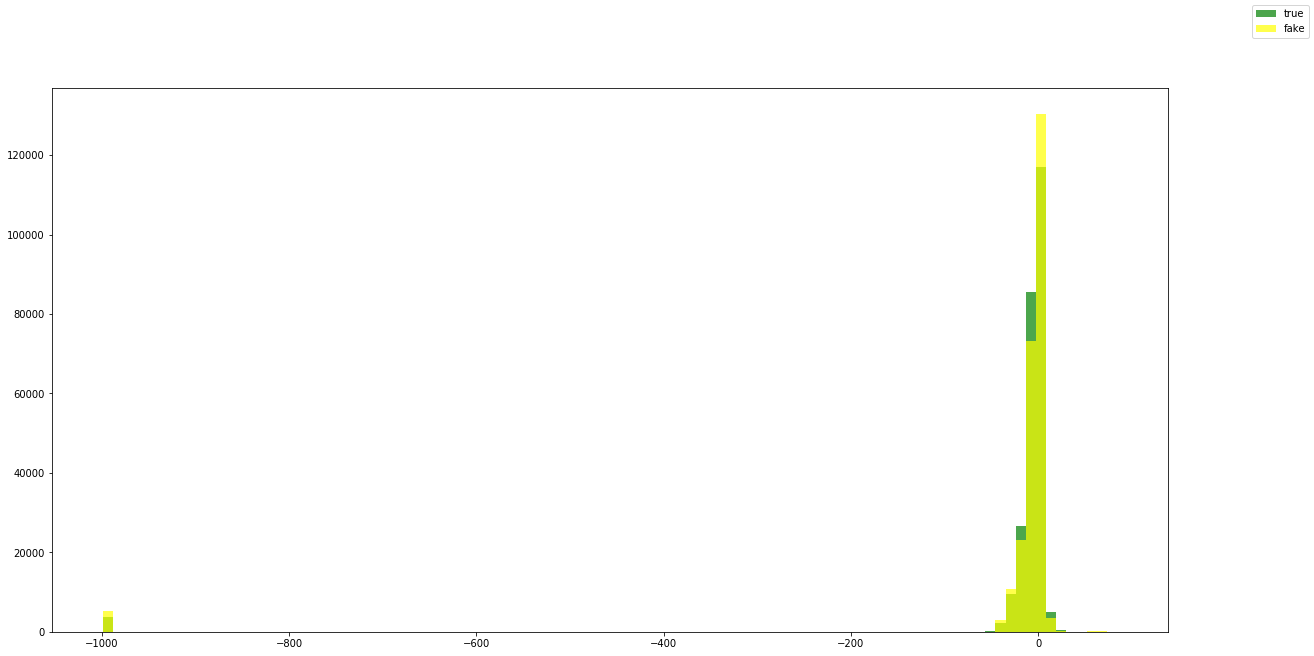

muon :  0.20661917352330594
RichDLLbt


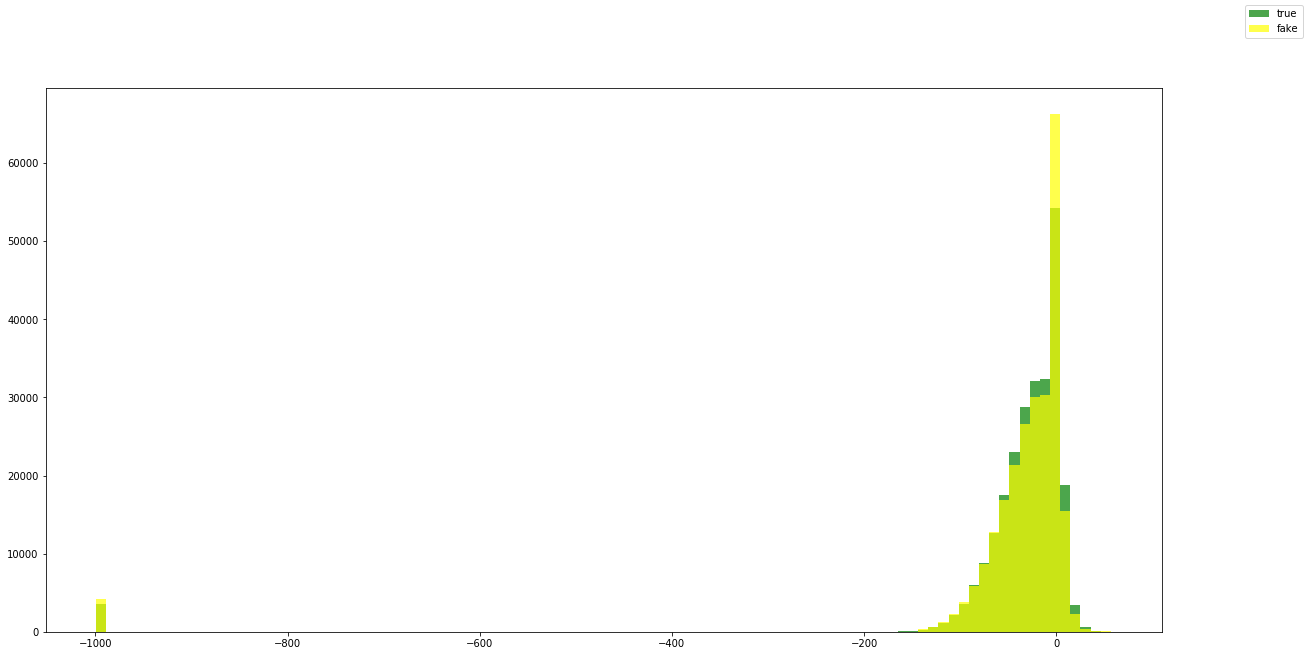

RichDLLk


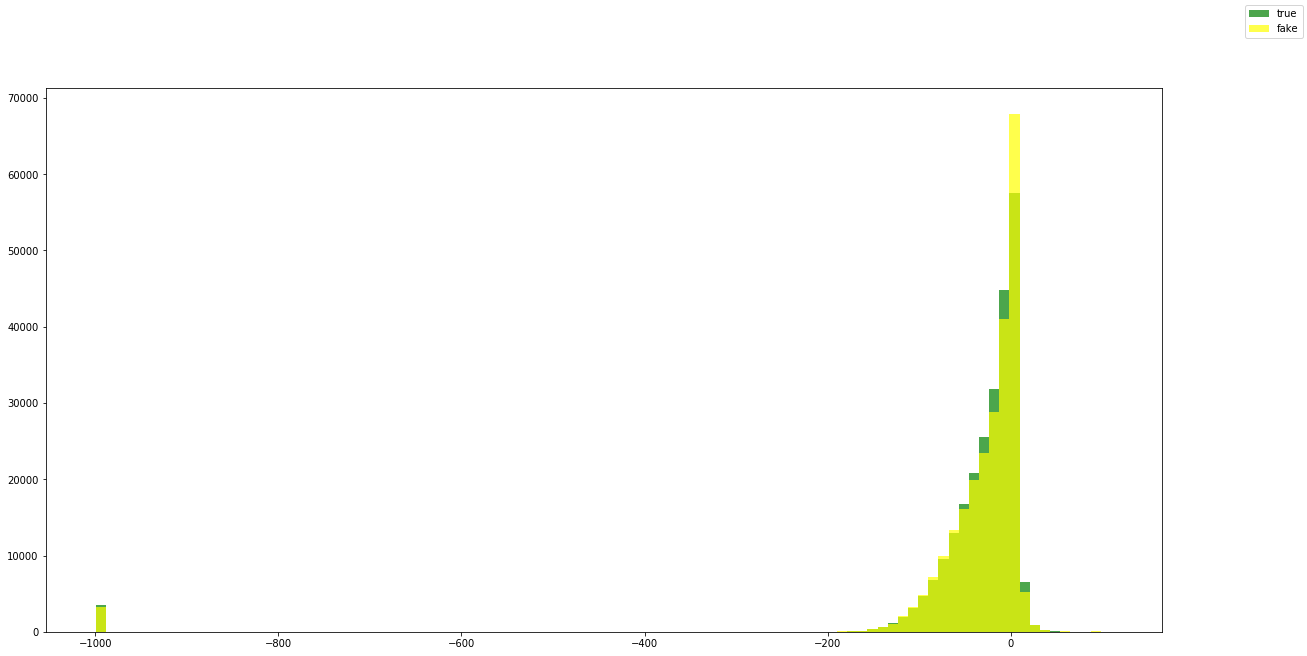

RichDLLmu


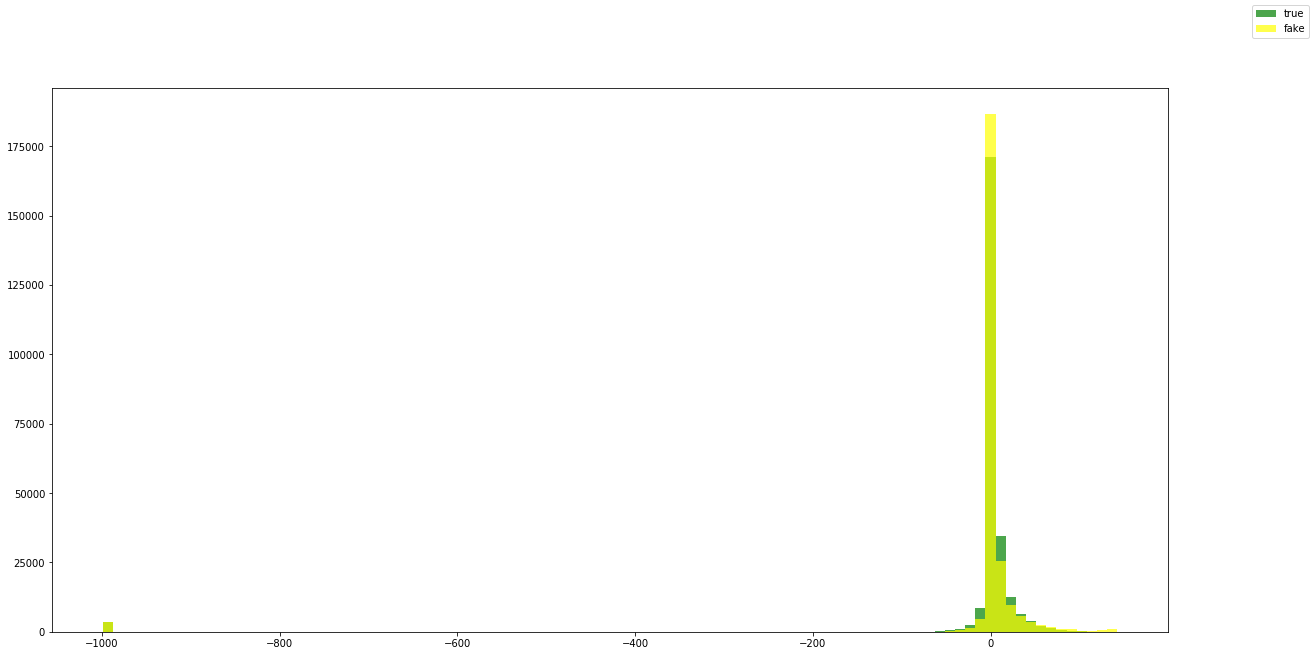

RichDLLp


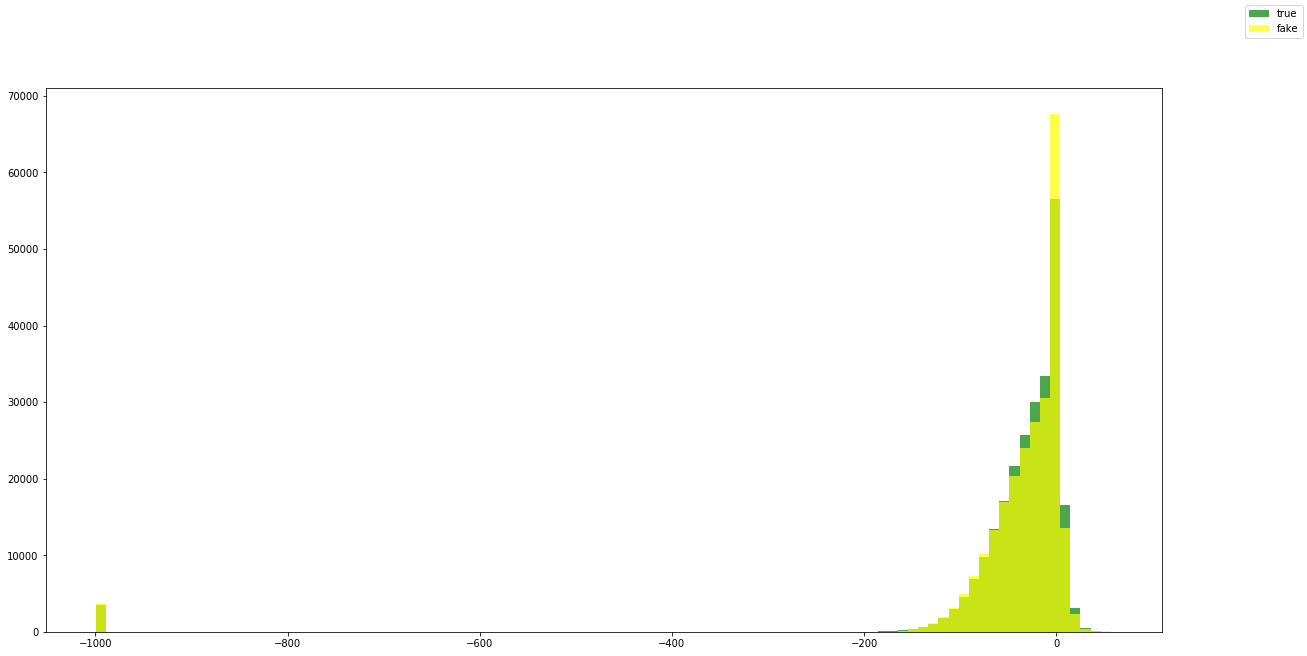

RichDLLe


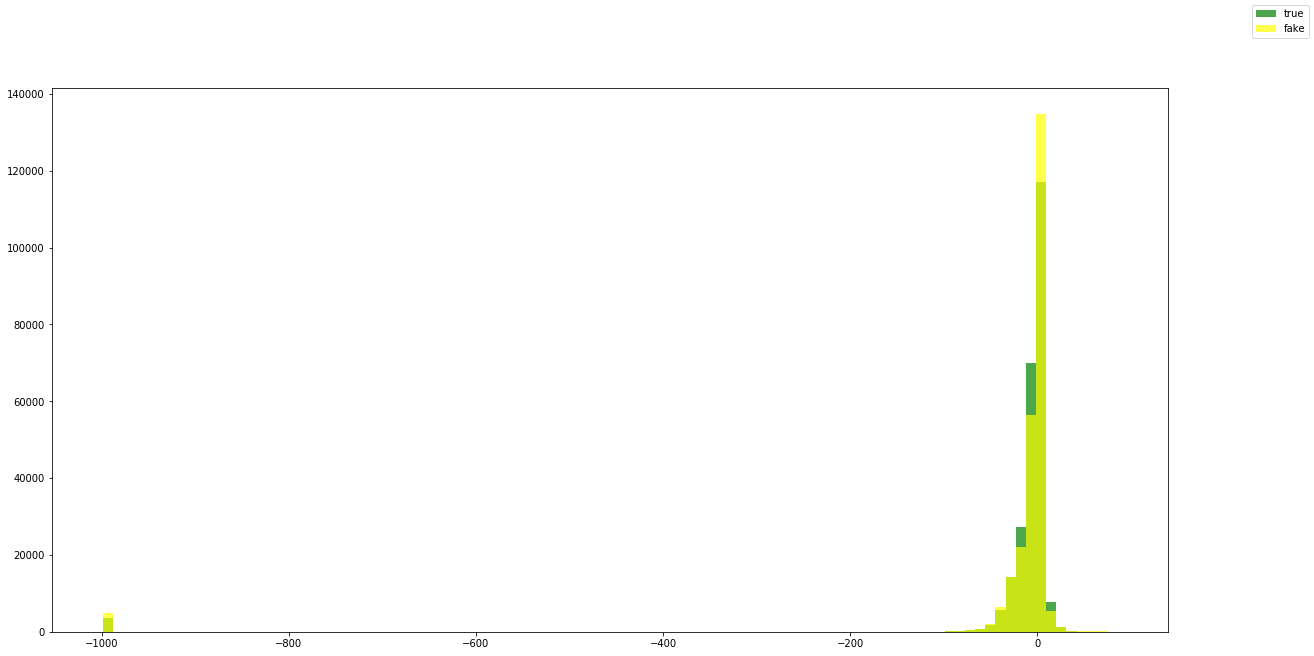

kaon :  0.17940871763487054
RichDLLbt


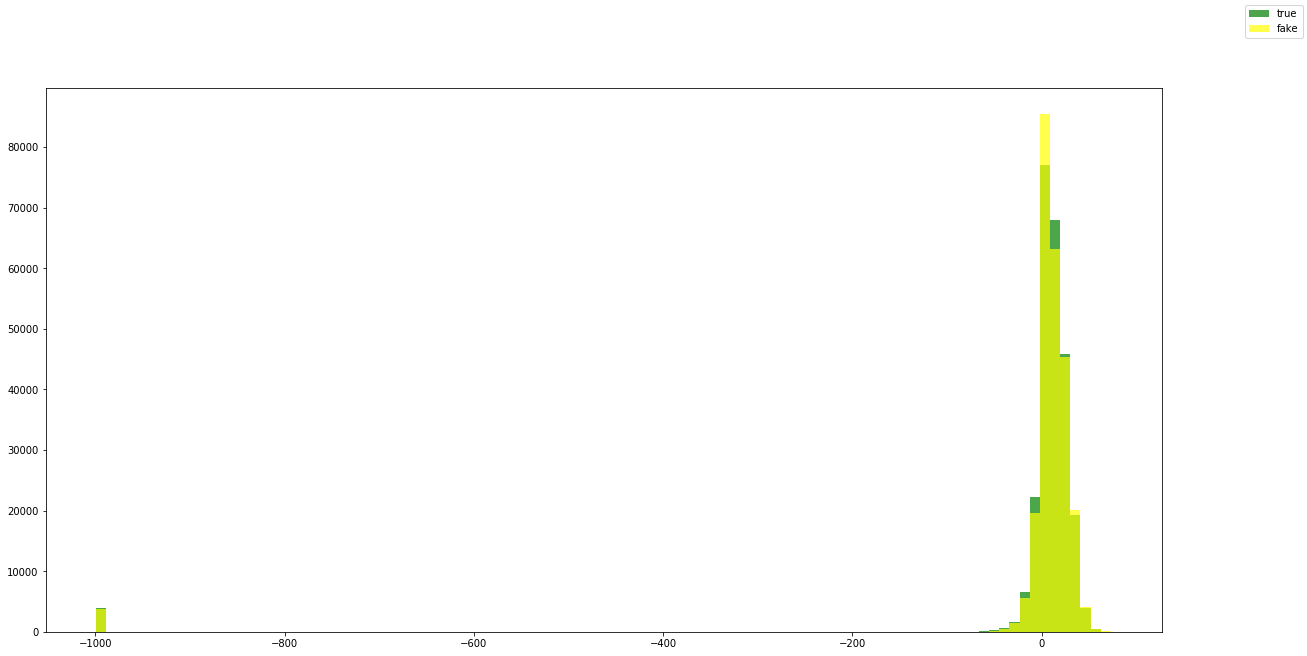

RichDLLk


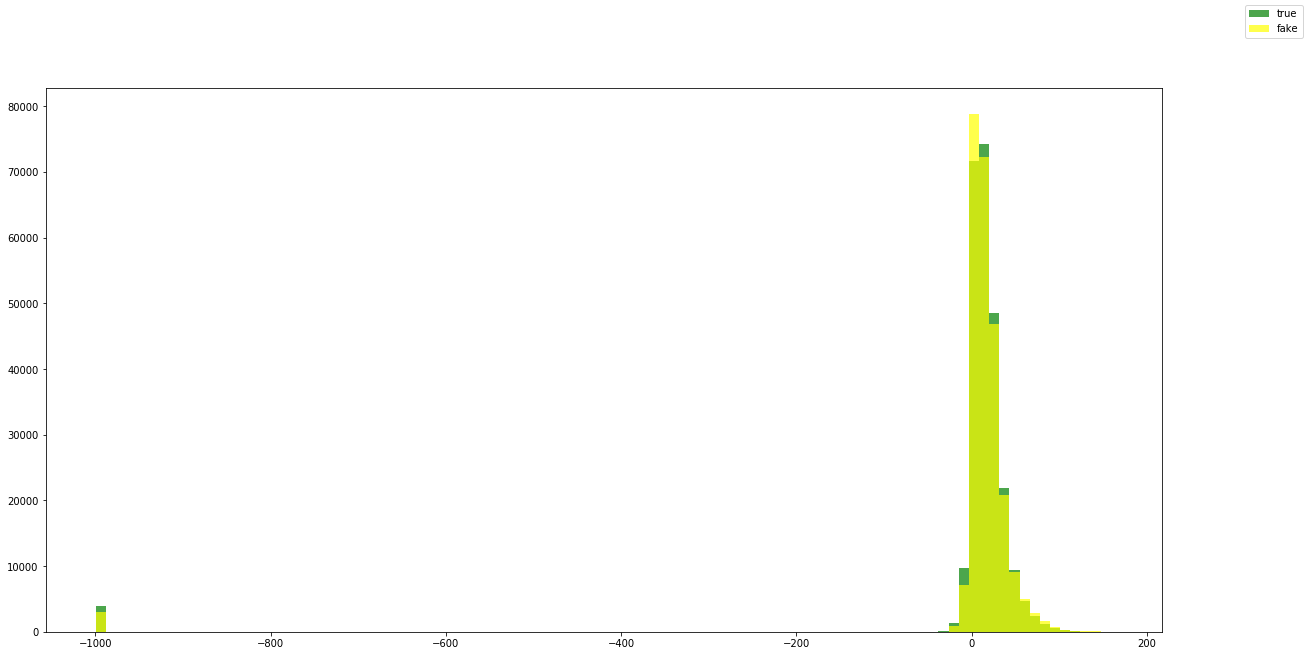

RichDLLmu


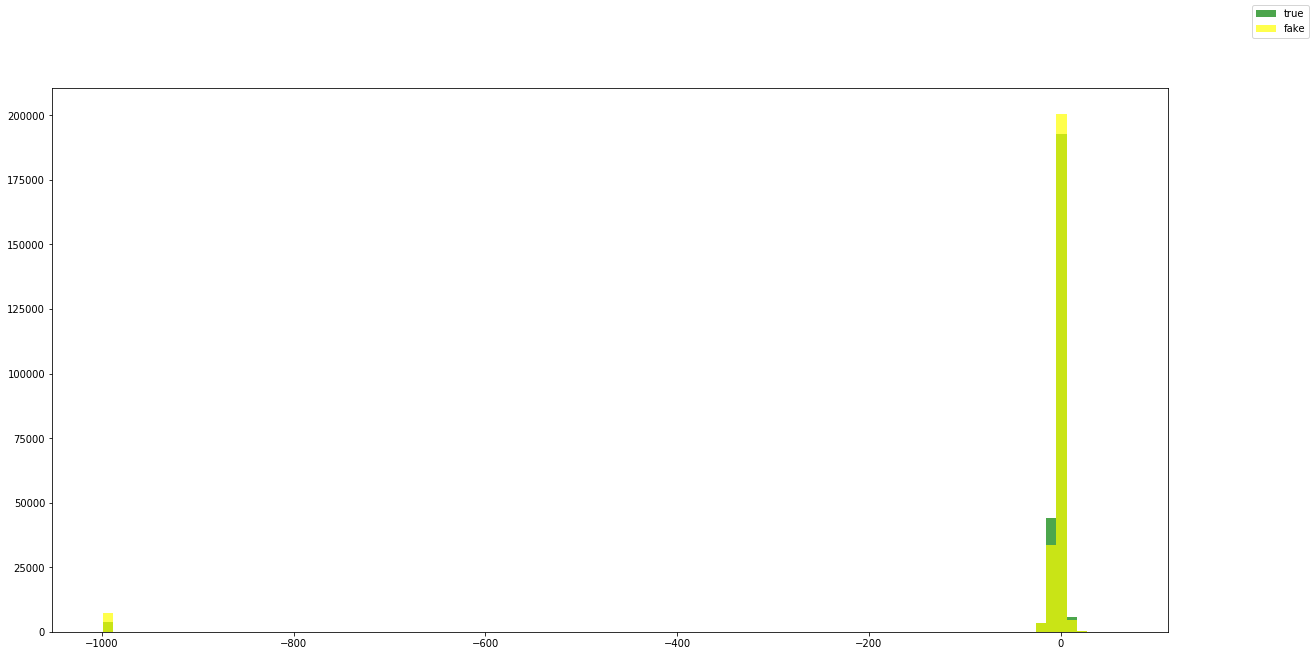

RichDLLp


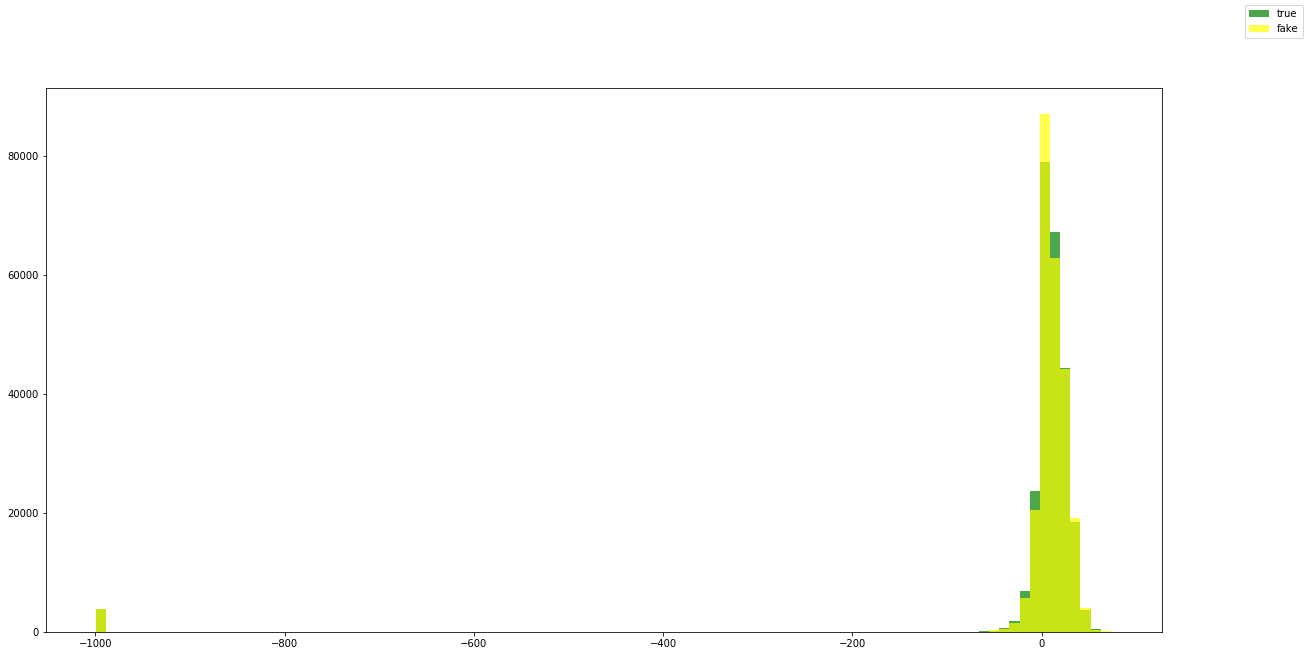

RichDLLe


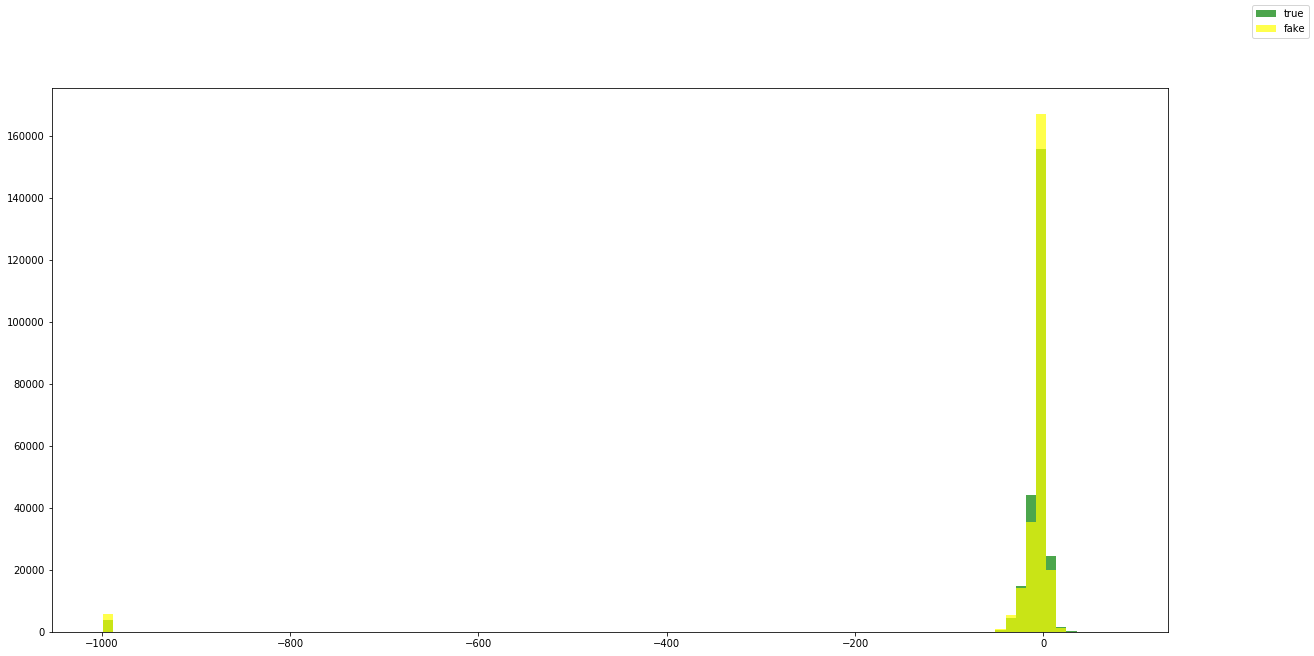

pion :  0.2786057711538308
RichDLLbt


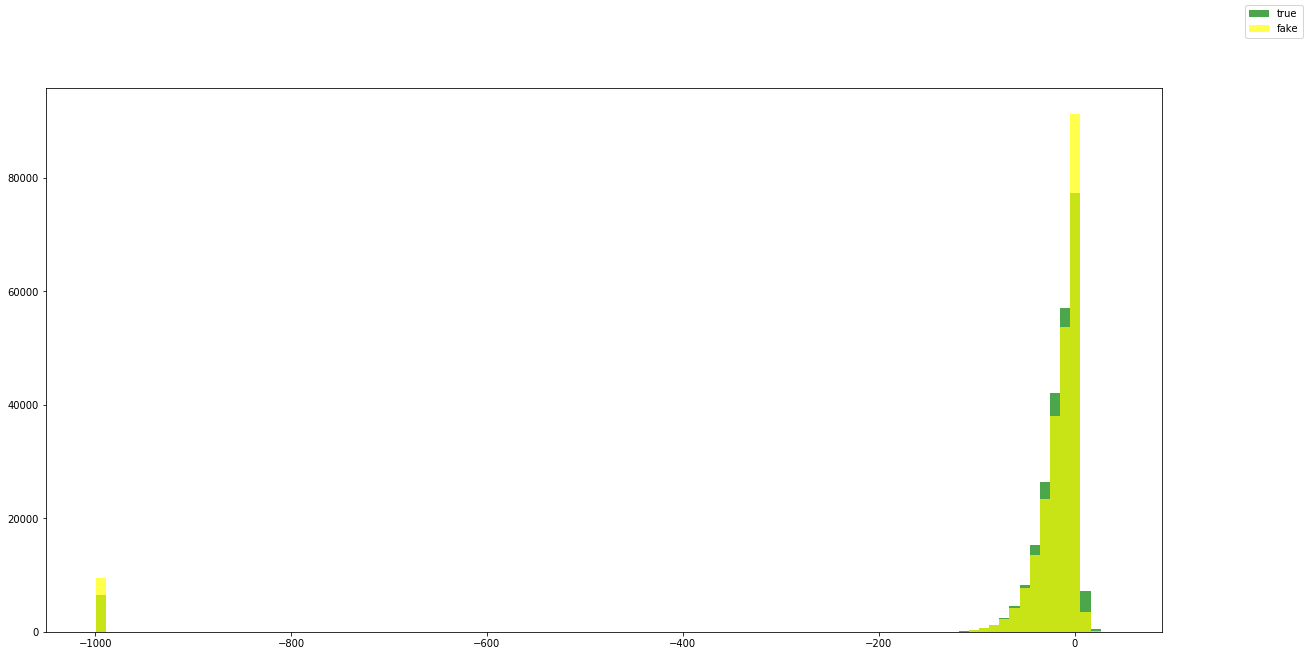

RichDLLk


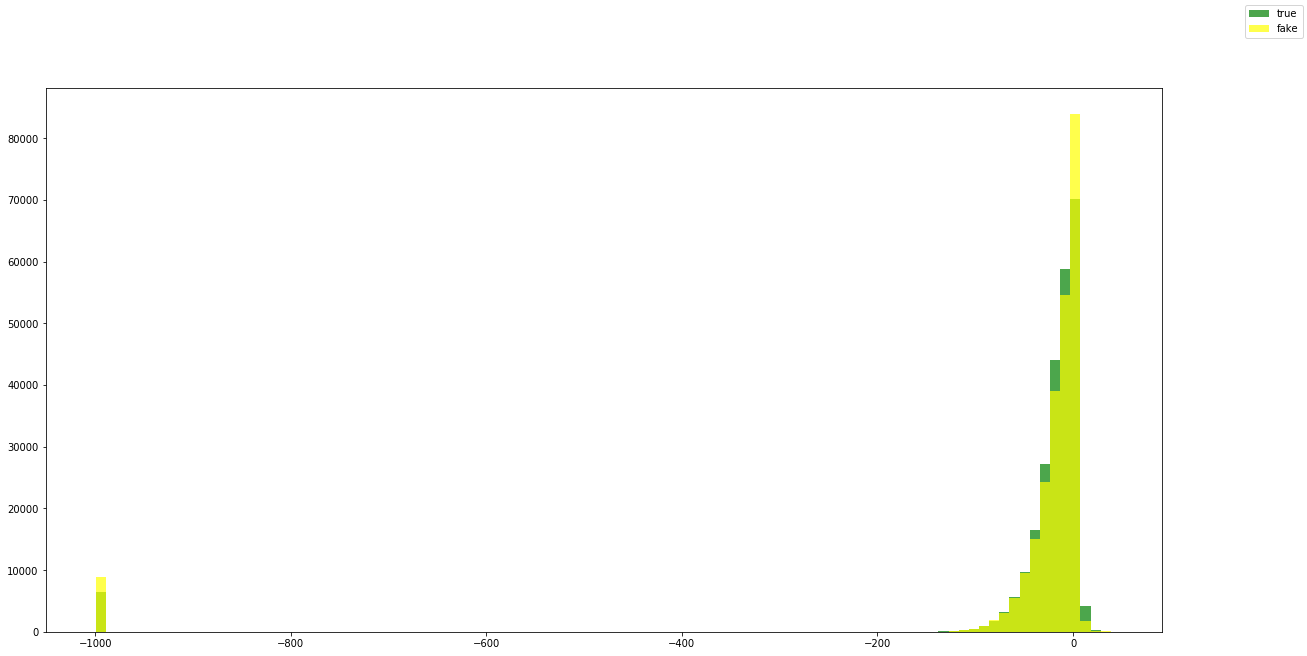

RichDLLmu


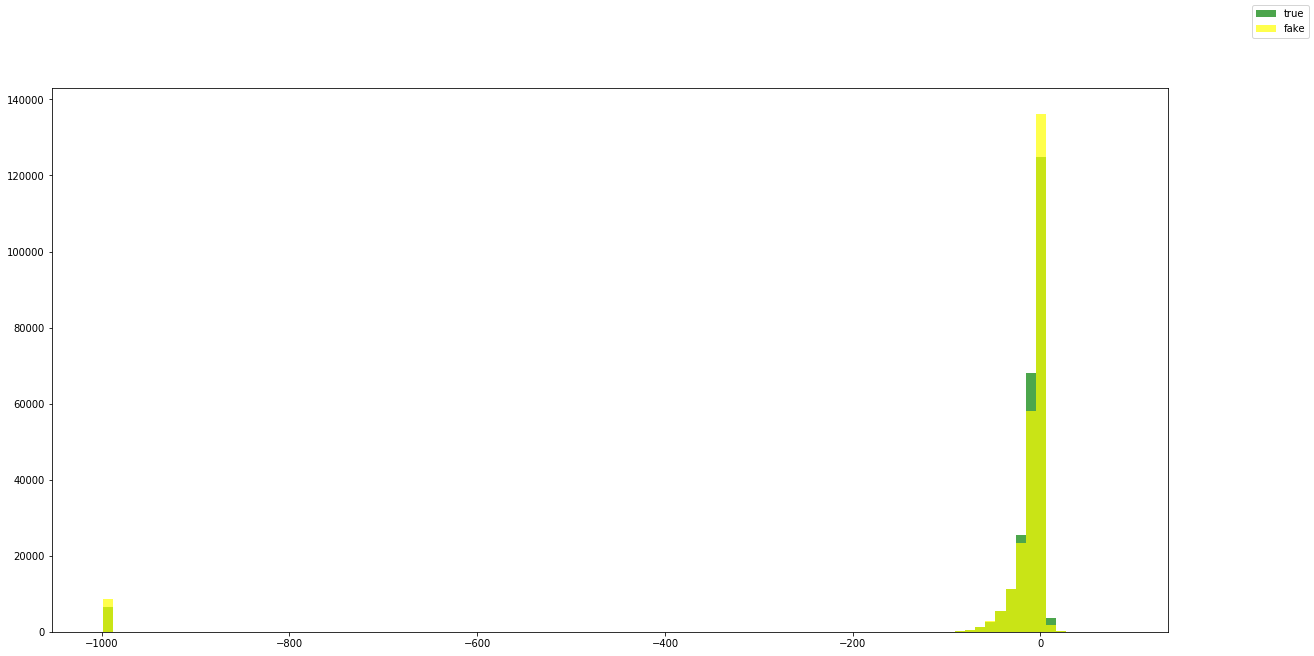

RichDLLp


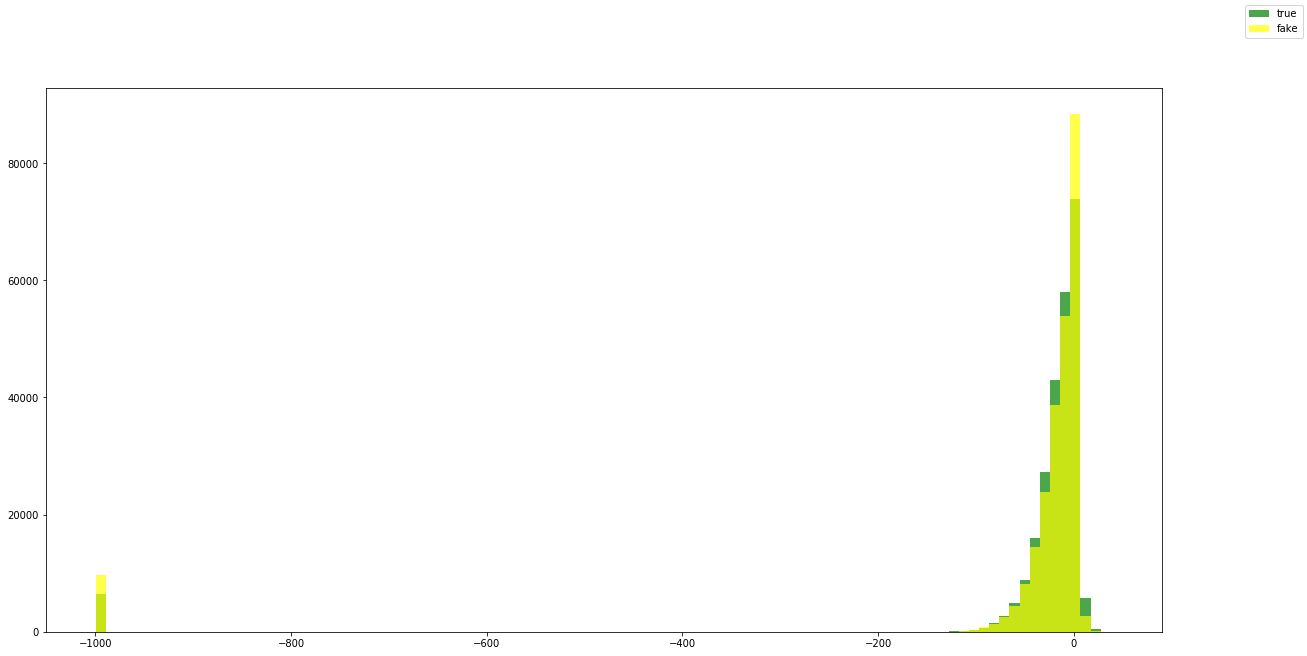

RichDLLe


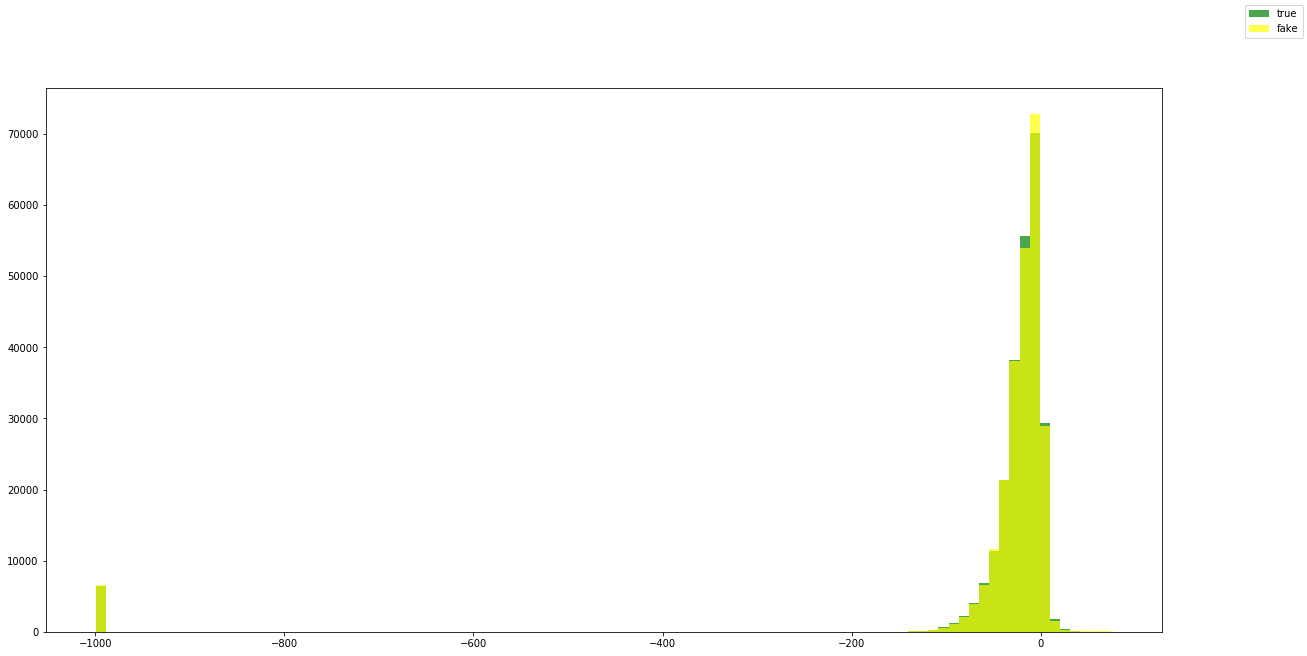

In [12]:
models_polluted = dict()
figs_polluted = defaultdict(dict)
scores_polluted = dict()

for particle in tqdm(['proton', 'muon', 'kaon', 'pion']):
    
    c_train = dataframes[particle]['train'][condition_cols]
    x_train = dataframes[particle]['train'][target_cols]
    c_test = dataframes[particle]['test'][condition_cols]
    x_test = dataframes[particle]['test'][target_cols]
    
    model = get_model()
    model.simulate_error_codes = False
    model.fit(
        c_train,
        x_train,
        start_epoch=0,
        num_epochs=50,
        n_critic=1,
        batch_size=512,
        writer=SummaryWriter(log_dir=Path(logdir, tag, particle)),
        num_workers=6,
    )
    models_polluted[particle] = model
    predicted = model.predict(c_test)
    reference = np.c_[x_test.values, c_test.values]
    generated = np.c_[predicted.values, c_test.values]
    score = score_func(generated, reference, n_slices=1000)
    scores_polluted[particle] = score
    print(particle, ': ', score)
    for col in target_cols:
        print(col)
        fig = plot_hist(x_test[col].values, predicted[col].values)
        figs_polluted[particle][col] = fig
        display(fig)
    print('='*100)
        

In [13]:
scores_polluted

{'proton': 0.18348473393893572,
 'muon': 0.20661917352330594,
 'kaon': 0.17940871763487054,
 'pion': 0.2786057711538308}

In [15]:
for particle in figs_polluted:
    for col in figs_polluted[particle]:
        p = Path(f'/_data/richgan/pics/{tag}/', particle)
        p.mkdir(parents=True, exist_ok=True)
        figs_polluted[particle][col].savefig(Path(p, f'{col}-polluted').with_suffix('.png').as_posix(), format='png')